In [1]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# disable warnings, use w caution
import warnings
warnings.filterwarnings('ignore')

# project specific libs
import os
import matplotlib.pyplot as plt
import pathlib

In [2]:
# project specific path
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/oa/'

###### Process Mapping Files ######

In [3]:
# from AC Q2 run of merged saliva stool
df_map = pd.read_csv(path + 'inputs/Qiime2_0/qiime_mapping_file.tsv', sep='\t', index_col=0)
q2_row = df_map.loc['#q2:types',:]
df_map = df_map.drop('#q2:types')

# change index so it matches metadata file
df_map.index = df_map.index.map(lambda x: x.split('.guma')[0])

# drop MOC and elution buffer
df_map = df_map.drop(['MOC.320','elutionbuffer.plate313'])

# grab metadata
df_meta = pd.read_csv(path + 'inputs/Metadata_OA.csv')

# rename 'Run_ID_Saliva' to be correct
df_meta['Timepoints'] = df_meta['Timepoints'].apply(lambda x: 'pre' if x == '0' else 'post')
df_meta['Patient_ID'] = df_meta['Patient_ID'].apply(lambda x: x[:-3])  
df_meta['Study_ID'] = df_meta['Study_ID'].apply(lambda x: x.split('_')[0][-3:]) 
df_outcomes = df_meta.copy()

# create per sample type mapping files
type_to_ST = {'saliva':'Saliva','stool':'fecal'}
type_to_df_map = {}

# split into specimen type
for t in type_to_ST:
    # subset on specimen type
    df_map_type = df_map[df_map['SpecimenType'] == type_to_ST[t]]

    # as to not overwrite df meta
    df_meta_type = df_meta.copy()

    # create new sample ID for specimen type and set as index
    df_meta_type['#SampleID'] = df_meta['Patient_ID'] + '-' + df_meta['Study_ID'] + '.' + df_meta['Timepoints'] + '.' + t
    df_meta_type = df_meta_type.set_index('#SampleID')

    # create full mapping file
    df_map_type = pd.concat([df_map_type, df_meta_type],axis=1)

    # use only sequenced samples
    df_map_type = df_map_type.dropna(how='any',subset='BarcodeSequence')

    # drop all na columns
    df_map_type = df_map_type.dropna(how='all',axis=1)

    # drop VAD OA 015 because misdx with PsA not OA
    # drop OAD007 in saliva bc possible contaminants
    if t == 'saliva':
        df_map_type = df_map_type.drop(['VAOAD-015.pre.saliva','VAOAD-015.post.saliva'])
        # df_map_type = df_map_type.drop(['OAD-007.pre.saliva','OAD-007.post.saliva'])

    if t == 'stool':
        df_map_type = df_map_type.drop(['VAOAD-015.pre.stool','VAOAD-015.post.stool'])

    # populate dict of mapping files
    type_to_df_map[t] = df_map_type

    # export for q2
    df_q2_type = pd.concat([q2_row.to_frame().T, df_map_type])
    df_q2_type.index.name = '#SampleID'
    df_q2_type.iloc[0,:] = 'categorical'
    df_q2_type.to_csv(path + 'inputs/qiime_mapping_file_' + t + '.tsv', sep='\t')
    df_q2_type = df_q2_type[df_q2_type['Adherece_antiinflam'].isin(['Moderate adherence', 'High adherence','categorical'])]
    df_q2_type.to_csv(path + 'inputs/qiime_mapping_file_' + t + '_adh.tsv', sep='\t')

    # split by response category
    df_q2_resp = df_q2_type[df_q2_type['WOMAC_P_Response'].isin(['categorical', 'Response'])]
    df_q2_resp.to_csv(path + 'inputs/qiime_mapping_file_' + t + '_adh_response.tsv', sep='\t')
    df_q2_nonresp = df_q2_type[df_q2_type['WOMAC_P_Response'].isin(['categorical', 'No response'])]
    df_q2_nonresp.to_csv(path + 'inputs/qiime_mapping_file_' + t + '_adh_noresponse.tsv', sep='\t')

    # split by timepoint
    df_q2_pre = df_q2_type[df_q2_type['Timepoint'].isin(['pre','categorical'])]
    df_q2_pre.to_csv(path + 'inputs/qiime_mapping_file_' + t + '_adh_pre.tsv', sep='\t')
    df_q2_post = df_q2_type[df_q2_type['Timepoint'].isin(['post', 'categorical'])]
    df_q2_post.to_csv(path + 'inputs/qiime_mapping_file_' + t + '_adh_post.tsv', sep='\t')

type_to_df_map['stool'].head()

,BarcodeSequence,LinkerPrimerSequence,Separate,Timepoint,Together,ContactEmail,ContactName,PrimaryInvestigator,Cohort,RawDataNotes,...,broccoli,Garbanzo_beans,pork,beef,burger,Total_omega3,Adherence_omega3,Total_omega6,Adherence_omega6,Total_o3_o6
#SampleID,,,,,,,,,,,,,,,,,,,,,
OAD-001.pre.stool,TTCAGTTCGTTA,CCGGACTACHVGGGTWTCTAAT,All,pre,OAD-001.pre.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-001.pre.stool.guma.plate313,...,0.0,0.0,0.0,0.0,0.0,NaN,Low adherence,NaN,Low adherence,0.0
OAD-001.post.stool,CGGCCAGAAGCA,CCGGACTACHVGGGTWTCTAAT,All,post,OAD-001.post.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-001.post.stool.guma.plate313,...,4.0,0.0,0.0,0.0,0.0,48.0,Low adherence,72.0,Low adherence,131.0
OAD-003.pre.stool,GACGTTAAGAAT,CCGGACTACHVGGGTWTCTAAT,All,pre,OAD-003.pre.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-003.pre.stool.guma.plate313,...,0.0,0.0,0.0,14.0,0.0,16.8,Low adherence,53.2,High adherence,75.0
OAD-003.post.stool,TCGCTACAGATG,CCGGACTACHVGGGTWTCTAAT,All,post,OAD-003.post.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-003.post.stool.guma.plate313,...,4.0,0.0,0.0,0.0,0.0,48.0,Low adherence,108.0,High adherence,171.0
OAD-004.pre.stool,ATGGGACCTTCA,CCGGACTACHVGGGTWTCTAAT,All,pre,OAD-004.pre.stool.guma.plate313,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,OAD-004.pre.stool.guma.plate313,...,2.8,0.0,0.0,0.0,0.0,2.8,Low adherence,28.0,Low adherence,35.8


###### Assess Outcomes ######

In [4]:
###
# Hypothesis 1: There will be a measurable difference in WOMAC pain response scores and 
# other outcomes from baseline to after the dietary intervention.
###

# outcome variables
outcomes = ['VAS_Pt', 'VAS_overall', 'WOMAC_pain', 'WOMAC_stiffness', 'WOMAC_activity', 'WOMAC_total', 'Pain_DETECT', 
            'CES_D', 'Helplesness', 'Magnification', 'Rumination', 'PCS_EN', 'Sleep_distrubance', 'PASE_walk', 'PASE_light', 
            #'PASE_gardening', # Where did this go? gardening_improve is binary
            'BMI']


# hypothesis 1
# create a new df_meta
df_meta = pd.read_csv(path + 'inputs/Metadata_OA.csv')

# rename 'Run_ID_Saliva' to be correct
df_meta['Timepoints'] = df_meta['Timepoints'].apply(lambda x: 'pre' if x == '0' else 'post')
df_meta['Patient_ID'] = df_meta['Patient_ID'].apply(lambda x: x[:-3])  
df_meta['Study_ID'] = df_meta['Study_ID'].apply(lambda x: x.split('_')[0][-3:]) 
df_meta['#SampleID'] = df_meta['Patient_ID'] + '-' + df_meta['Study_ID'] + '.' + df_meta['Timepoints'] + '.stool'
df_meta = df_meta.set_index('#SampleID')

# convert % to floats for calculations down the road
bin = []
cont = []
df_paired_os = []
for w in outcomes:
    df_w = df_meta[w]
    if df_w.nunique() > 2: # do spearman
        df_meta[w] = df_meta[w].astype(str).str.replace('%','').astype(float).values
        cont.append(w)
    else:
        bin.append(w)

    # compute difference and store it
    df_md = df_meta.copy()
    df_md['SubjectID'] = df_md['Patient_ID'] + df_md['Study_ID']
    
    # first drop unpaired samples
    s_remove = []
    for s in list(df_md['SubjectID'].values):
        if len(df_md[df_md['SubjectID'] == s]) != 2:
            s_remove.append(s)
    df_md = df_md.loc[~df_md['SubjectID'].isin(s_remove),:] # careful not to use ([s_remove])
    
    # set vars
    group_var = 'Timepoints'
    pair_var = 'SubjectID'
    groups = ['pre','post']
    
    # get paired per indiv pair
    pair_to_diff = {}
    for p in list(df_md[pair_var].values):
        df = df_md[df_md[pair_var] == p]
        t0 = float(df[df[group_var] == groups[0]][w].values)
        tf = float(df[df[group_var] == groups[1]][w].values)
        pair_to_diff[p] = tf - t0
    
    df_paired_o = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=[w + '_diff'])
    df_paired_os.append(df_paired_o)

df_meta_paired = pd.concat([*df_paired_os], axis=1)    

print(bin)
print(cont)

# split into all and mod high only
a = 'modhigh'
job = 'jobs02'
df_meta = df_meta[df_meta['Adherece_antiinflam'].isin(['Moderate adherence', 'High adherence'])]
        
print(len(df_meta))

df_results = pd.DataFrame(columns=['var','effect','pval','stat'])
# do post treatment vals of binary vars differ from pre treatment 'unpaired'
for b in bin:
    ct_table_ind=pd.crosstab(df_meta["Timepoints"],df_meta[b])
    chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table_ind)
    row=pd.DataFrame.from_dict({'var': [b],'effect':[chi2_stat],'pval':[p],'stat':['chi2']})
    df_results = pd.concat([df_results, row])

# fishers exact
for b in bin:
    ct_table_ind=pd.crosstab(df_meta["Timepoints"],df_meta[b])
    fisher, p = scipy.stats.fisher_exact(ct_table_ind)
    row=pd.DataFrame.from_dict({'var': [b],'effect':[t],'pval':[p],'stat':['fisher']})
    df_results = pd.concat([df_results, row])
    
# do post treatment vals of continuous vars differ from pre treatment unpaired
df_pre = df_meta[df_meta['Timepoints'] == 'pre']
df_post = df_meta[df_meta['Timepoints'] == 'post']
for c in cont:
    try:
        W,p = scipy.stats.mannwhitneyu(x=df_pre[c].values,y=df_post[c].values, nan_policy='omit')
    except:
        W,p = 0, 1
    row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['mwu']})
    if p < 0.05:
        ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
        sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
    
        # ax.axes.set_title("Title",fontsize=48)
        ax.set_ylabel(c,fontsize=16)
        ax.set_xlabel('Timepoints',fontsize=16)                
        ax.tick_params(labelsize=16)
        sns.despine()
        plt.tight_layout()
        plt.savefig(path + 'outputs/' + job + '/mwu_' + c  + '.pdf')
        plt.close()            
    row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['MWU']})
    df_results = pd.concat([df_results, row])
    
df_pre = df_meta[df_meta['Timepoints'] == 'pre']
df_post = df_meta[df_meta['Timepoints'] == 'post']
for c in cont:
    t,p = scipy.stats.ttest_ind(a=df_pre[c].values,b=df_post[c].values, nan_policy='omit')
    row=pd.DataFrame.from_dict({'var': [c],'effect':[t],'pval':[p],'stat':['ttest']})
    if p < 0.05:
        ax = sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v')
        sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette='dark:grey', hue=None, orient='v')
    
        # ax.axes.set_title("Title",fontsize=48)
        ax.set_ylabel(c,fontsize=16)
        ax.set_xlabel('Timepoints',fontsize=16)                
        ax.tick_params(labelsize=16)
        sns.despine()
        plt.tight_layout()
        plt.savefig(path + 'outputs/' + job + '/tt_' + c  + '.pdf')
        plt.close()            
    row=pd.DataFrame.from_dict({'var': [c],'effect':[t],'pval':[p],'stat':['ttest']})
    df_results = pd.concat([df_results, row])

# unpaired and then paired
df_pre = df_meta[df_meta['Timepoints'] == 'pre']
df_post = df_meta[df_meta['Timepoints'] == 'post']
for c in cont:
    W,p = scipy.stats.wilcoxon(x=df_pre[c].values,y=df_post[c].values, nan_policy='omit')
    row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['WSR']})
    if p < 0.05:
        ax = sns.swarmplot(data=df_meta, x='Timepoints', y=c, hue='WOMAC_P_Response', palette=['b','r'], orient='v')
        for (x0, y0), (x1, y1) in zip(ax.collections[0].get_offsets(), ax.collections[1].get_offsets()):
            ax.plot([x0, x1], [y0, y1], color='black', ls=':', zorder=0)
        sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v', hue=None, boxprops=dict(alpha=.3))
        
        # ax.axes.set_title("Title",fontsize=48)
        ax.set_ylabel(c,fontsize=16)
        ax.set_xlabel('Timepoints',fontsize=16)                
        ax.tick_params(labelsize=16)
        sns.despine()
        plt.tight_layout()
        plt.savefig(path + 'outputs/' + job + '/wsr_' + c  + '.pdf')
        plt.close()            
    row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['WSR']})
    df_results = pd.concat([df_results, row])

df_pre = df_meta[df_meta['Timepoints'] == 'pre']
df_post = df_meta[df_meta['Timepoints'] == 'post']
for c in cont:
    t,p = scipy.stats.ttest_rel(a=df_pre[c].values,b=df_post[c].values, nan_policy='omit')
    row=pd.DataFrame.from_dict({'var': [c],'effect':[W],'pval':[p],'stat':['pairedt']})
    if p < 0.05:
        ax = sns.swarmplot(data=df_meta, x='Timepoints', y=c, palette=['b','r'], hue='WOMAC_P_Response',orient='v')
        for (x0, y0), (x1, y1) in zip(ax.collections[0].get_offsets(), ax.collections[1].get_offsets()):
            ax.plot([x0, x1], [y0, y1], color='black', ls=':', zorder=0)
        sns.boxplot(data=df_meta, x='Timepoints', y=c, orient='v', hue=None, boxprops=dict(alpha=0.3))
        
        # ax.axes.set_title("Title",fontsize=48)
        ax.set_ylabel(c,fontsize=16)
        ax.set_xlabel('Timepoints',fontsize=16)                
        ax.tick_params(labelsize=16)
        sns.despine()
        plt.tight_layout()
        plt.savefig(path + 'outputs/' + job + '/pairedt_' + c  + '.pdf')
        plt.close()          
    row=pd.DataFrame.from_dict({'var': [c],'effect':[t],'pval':[p],'stat':['pairedt']})
    df_results = pd.concat([df_results, row])

df_results.to_csv(path + 'outputs/' + job + '/outcome_testing.tsv', sep='\t')
df_results.head()
    

[]
['VAS_Pt', 'VAS_overall', 'WOMAC_pain', 'WOMAC_stiffness', 'WOMAC_activity', 'WOMAC_total', 'Pain_DETECT', 'CES_D', 'Helplesness', 'Magnification', 'Rumination', 'PCS_EN', 'Sleep_distrubance', 'PASE_walk', 'PASE_light', 'BMI']
32


,var,effect,pval,stat
0,VAS_Pt,198.5,0.008316,MWU
0,VAS_overall,168.5,0.131314,MWU
0,WOMAC_pain,170.0,0.017900,MWU
0,WOMAC_stiffness,172.5,0.013052,MWU
0,WOMAC_activity,164.5,0.032592,MWU


###### Grab Paired Alpha ######

In [5]:
###
# Hypothesis 2: There will be an association between oral and gut microbiome and pain outcomes
###
# construct alpha, beta and paired alpha dataframes
g_to_dfd = {}
# g_test = ['stool','saliva_adh', 'stool_adh', 'saliva']
g_test = ['saliva_adh', 'stool_adh']

for g in g_test:
    # maps diversity type to dataframe
    g_to_dfd[g] = {}

    # get alpha diversities
    df_alpha = pd.read_csv(path + 'outputs/Qiime2_' + g + '/metadata.tsv', sep='\t', index_col=0)
    df_alpha = df_alpha.drop('#q2:types')
    df_alpha['SubjectID'] = df_alpha['Patient_ID'] + df_alpha['Study_ID']
    df_alpha = df_alpha[['SubjectID', 'Timepoints', 'shannon_entropy']]
    g_to_dfd[g]['alpha'] = df_alpha

    # get paired alpha div, first drop unpaired samples
    s_remove = []
    for s in list(df_alpha['SubjectID'].values):
        if len(df_alpha[df_alpha['SubjectID'] == s]) != 2:
            s_remove.append(s)
    df_alpha = df_alpha.loc[~df_alpha['SubjectID'].isin(s_remove),:] # careful not to use ([s_remove])
    
    # set vars
    alpha_metric = 'shannon_entropy'
    group_var = 'Timepoints'
    pair_var = 'SubjectID'
    groups = ['pre','post']
    
    # get paired per indiv pair
    pair_to_diff = {}
    for p in list(df_alpha[pair_var].values):
        df = df_alpha[df_alpha[pair_var] == p]
        alpha_0 = float(df[df[group_var] == groups[0]][alpha_metric].values)
        alpha_1 = float(df[df[group_var] == groups[1]][alpha_metric].values)
        pair_to_diff[p] = alpha_1 - alpha_0
    
    df_paired_alpha = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=[alpha_metric + '_diff'])
    g_to_dfd[g]['paired_alpha'] = df_paired_alpha

    # get beta div
    df_beta = pd.read_csv(path + 'outputs/Qiime2_' + g + '/core_metrics_results/distance-matrix.tsv',
                              sep='\t', index_col=0)
        
    # grab twin to pair dict
    pair_to_ids = {}
    for p in list(df_alpha[pair_var].values):
        df = df_alpha[df_alpha[pair_var] == p]
        id_0 = str(df[df[group_var] == groups[0]].index.values[0])
        id_1 = str(df[df[group_var] == groups[1]].index.values[0])
        pair_to_ids[p] = (id_0, id_1)
    
    # get distances for each twin pair per beta div matrix    
    pair_to_dist = {}
    for p in list(df_alpha[pair_var].values):
        id_0, id_1 = pair_to_ids[p]
        pair_to_dist[p] = df_beta.loc[id_0, id_1]
    
    df_paired_beta = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['Bray_Curtis'])
    g_to_dfd[g]['paired_beta'] = df_paired_beta

g_to_dfd['stool_adh']['paired_beta'].head()

,Bray_Curtis
OAD001,0.6672
OAD003,0.2837
OAD004,0.4237
OAD005,0.3257
OAD006,0.1022


###### Chi2 Association of Outcome with Alpha ######

In [6]:
# Testing for each sample type for (1) all and (2) high adh only
# (A) Chisq of quartiles with adherence 
# (B) MWU/TT unpaired of outcomes against distance

def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(scipy.stats.chi2_contingency(ctsum.fillna(0)))

d_to_metric = {
    'alpha': 'shannon_entropy',
}
group_var = 'Adherece_antiinflam'

dfd_to_merge = {}
g_test = ['saliva_adh', 'stool_adh']

for g in g_test:
    dfd_to_merge[g] = {}

gs = []
ds = []
os = []
stats = []
ts = []
ps = []

arr = [gs,ds,os,stats,ts,ps]

def append_results(arr, val):
    for a,v in zip(arr,val):
        a.append(v)
    return arr

# for each sample type, grab relevant mapping file
# g_test = saliva, saliva_adh, stool, etc.
for g in g_test:
    for d in d_to_metric:
        # grab relevant diversity df
        df_div = g_to_dfd[g][d]

        if d == 'alpha':
            # df_div = df_div[df_div['Timepoints'] == 'pre']
            # df_div = df_div.set_index('SubjectID').drop('Timepoints',axis=1)
            # df_div = df_div.set_index('SubjectID').drop('Timepoints',axis=1)
            df_div['shannon_entropy'] = df_div['shannon_entropy'].astype(float)

        # merge with df of metadata var        
        # grab relevant sample IDs
        # g = saliva_adh
        idx = 'Run_ID_' + g.split('_')[0].capitalize()
        df_meta_sub = df_meta.dropna(subset=idx)
        df_meta_sub = df_meta_sub.set_index(idx)
        df_merge = pd.concat([df_meta_sub,df_div],axis=1)

        # subset on adh only
        df_merge = df_merge[df_merge[group_var].isin(['Moderate adherence', 'High adherence'])]

        # test association of div with outcomes
        for o in ['WOMAC_P_Response']: #  outcomes:                    
            # test association of adherence with pain outcomes
            div_metric = d_to_metric[d]
            x,p,dof,ef = chisq_of_df_cols(df_merge, group_var, o)
            arr = append_results(arr, ['metadata',group_var,o,'chisq',x,p])
            
            ax = sns.boxplot(data=df_merge, x=o, y=div_metric)
            sns.swarmplot(data=df_merge, x=o, y=div_metric, palette='dark:grey')
            sns.despine()
        
            plt.tight_layout()
            plt.savefig(path + 'outputs/jobs06/rvnr_nondiff_' + g + '_' + o + '_' + d + '.pdf')
            plt.close()          
        
            u, p = scipy.stats.mannwhitneyu(df_merge[df_merge[o] == 'Response'][div_metric].values, 
                                            df_merge[df_merge[o] == 'No response'][div_metric].values, 
                                            nan_policy='omit')

            arr = append_results(arr, [g,d,o,'mwu',t,p])

            t, p = scipy.stats.ttest_ind(df_merge[df_merge[o] == 'Response'][div_metric].values, 
                                            df_merge[df_merge[o] == 'No response'][div_metric].values, 
                                            nan_policy='omit')

            arr = append_results(arr, [g,d,o,'tt',t,p])

        # save results
        dfd_to_merge[g][d] = df_merge

        # export to Q2
        # df_q2_type = df_merge.set_index(['Together'])
        df_q2_type = df_merge.copy()
        q2_row = pd.Series(data=['categorical' for i in range(len(df_merge.columns))], 
                           index=list(df_merge.columns.values), dtype=str, name='#q2:types')
        df_q2_type = pd.concat([q2_row.to_frame().T, df_q2_type])
        df_q2_type.index.name = '#SampleID'
        df_q2_type.index = df_q2_type.index.map(lambda x: x.split('.guma')[0])
        # df_q2_type.to_csv(path + 'inputs/qiime_mapping_file_' + d + '_' + g + 'aggregate_outcomes.tsv', sep='\t')

df_results = pd.DataFrame.from_dict({
    'group': gs,
    'div': ds,
    'outcome': os,
    'statistic': stats,
    'test_stat': ts,
    'pval': ps
})
# df_results.to_csv(path + 'outputs/df_results_aggregate.tsv', sep='\t')
# df_results.head()
# df_results[df_results['pval'] < 0.05]
df_results

,group,div,outcome,statistic,test_stat,pval
0,metadata,Adherece_antiinflam,WOMAC_P_Response,chisq,0.232031,0.630022
1,saliva_adh,alpha,WOMAC_P_Response,mwu,1.153857,0.788413
2,saliva_adh,alpha,WOMAC_P_Response,tt,0.756449,0.456450
3,metadata,Adherece_antiinflam,WOMAC_P_Response,chisq,0.232031,0.630022
4,stool_adh,alpha,WOMAC_P_Response,mwu,0.756449,0.980536
5,stool_adh,alpha,WOMAC_P_Response,tt,0.182238,0.856866


In [7]:
# expand previous to all data, paired and unpaired diversities
d_to_metric = {
    'pre_alpha': 'shannon_entropy',
    'post_alpha': 'shannon_entropy',
    'paired_alpha': 'shannon_entropy_diff',
    'paired_beta': 'Bray_Curtis' # 'Unweighted_Unifrac',
}
group_var = 'Adherece_antiinflam'

dfd_to_merge = {}
g_test = ['stool_adh','saliva_adh']
for g in g_test:
    dfd_to_merge[g] = {}

gs = []
ds = []
os = []
stats = []
ts = []
ps = []

arr = [gs,ds,os,stats,ts,ps]

def append_results(arr, val):
    for a,v in zip(arr,val):
        a.append(v)
    return arr

# for each sample type, grab relevant mapping file
# g_test = saliva, saliva_adh, stool, etc.
d_to_map = {}

for g in g_test:
    # drop duplicates so you have sample mapping to adh
    df_map_sub = type_to_df_map[g.split('_')[0]]
    df_map_sub.index = df_map_sub.index.map(lambda x: x.split('.')[0].replace('-',''))
    df_map_sub = df_map_sub.dropna(how='any',subset=group_var,axis=0)           
    
    # figure out which samples to keep
    # i.e. samples that have a pre and post time point
    keep = []
    for i in list(df_map_sub.index.values):
        if len(df_map_sub.loc[i,:]) == 2:
            keep.append(i)

    # get unique entires in sorted order
    # at this point we are only concerned with differences in values, 
    # as we've dropped samples with only one endpoint val
    save = []
    [save.append(x) for x in keep if x not in save]
    df_map_sub = df_map_sub.loc[save,:]

    # this double populates as OAD001 is an index twice, so the diff fills to both the pre and post col
    for o in outcomes:
        df_map_sub[o + '_diff'] = df_map_sub[df_map_sub['Timepoint'] == 'post'][o] - df_map_sub[df_map_sub['Timepoint'] == 'pre'][o] 

    # here we keep only the pre, but everything is identical b/w pre and post
    df_dropdup = df_map_sub[~df_map_sub.index.duplicated(keep='first')]
    d_to_map[g] = df_dropdup
    
    for d in d_to_metric:
        # grab relevant diversity df
        if d == 'pre_alpha' or d == 'post_alpha':
            df_div = g_to_dfd[g]['alpha']
        else:
            df_div = g_to_dfd[g][d]
        div_metric = d_to_metric[d]

        # when associating alpha div vs outcomes, look at if starting adiv predicts outcome
        if d == 'pre_alpha':
            df_div = df_div[df_div['Timepoints'] == 'pre']
            df_div = df_div.set_index('SubjectID').drop('Timepoints',axis=1)
            df_div = df_div.astype(float)

        if d == 'post_alpha':
            df_div = df_div[df_div['Timepoints'] == 'post']
            df_div = df_div.set_index('SubjectID').drop('Timepoints',axis=1)
            df_div = df_div.astype(float)

        # merge with df of metadata var        
        df_merge = pd.concat([df_dropdup,df_div],axis=1)

        # drop na in barcodes if samples not sequenced both pre and post
        df_merge = df_merge.dropna(how='any',subset='BarcodeSequence')
        
        # test association of div with outcomes
        for o in ['WOMAC_P_Response']:                     
            # test association of adherence with pain outcomes
            # flip x and y for horizontal
            ax = sns.boxplot(data=df_merge, x=o, y=div_metric)
            sns.swarmplot(data=df_merge, x=o, y=div_metric, palette='dark:grey')
            sns.despine()
        
            plt.tight_layout()
            plt.savefig(path + 'outputs/jobs06/WOMAC_barplot_' + g + '_' + o + '_' + d + '.pdf')
            plt.close()          

            # MWU and ttest
            u, p = scipy.stats.mannwhitneyu(df_merge[df_merge[o] == 'Response'][div_metric].values, 
                                            df_merge[df_merge[o] == 'No response'][div_metric].values, 
                                            nan_policy='omit')

            arr = append_results(arr, [g,d,o,'mwu',t,p])

            t, p = scipy.stats.ttest_ind(df_merge[df_merge[o] == 'Response'][div_metric].values, 
                                         df_merge[df_merge[o] == 'No response'][div_metric].values, 
                                         nan_policy='omit',
                                         equal_var=False)

            arr = append_results(arr, [g,d,o,'tt',t,p])
         
        # save results
        dfd_to_merge[g][d] = df_merge

        # export to Q2
        df_q2_type = df_merge.set_index(['Together'])
        q2_row = pd.Series(data=['categorical' for i in range(len(df_merge.columns))], 
                           index=list(df_merge.columns.values), dtype=str, name='#q2:types')
        df_q2_type = pd.concat([q2_row.to_frame().T, df_q2_type])
        df_q2_type.index.name = '#SampleID'
        df_q2_type.index = df_q2_type.index.map(lambda x: x.split('.guma')[0])
        # df_q2_type.to_csv(path + 'inputs/qiime_mapping_file_' + d + '_' + g + '_outcomes.tsv', sep='\t')

df_results = pd.DataFrame.from_dict({
    'group': gs,
    'div': ds,
    'outcome': os,
    'statistic': stats,
    'test_stat': ts,
    'pval': ps
})
# df_results.to_csv(path + 'outputs/df_results_diff.tsv', sep='\t')

# df_results.head()
# the div==alpha results test whether pre-alpha div state associates with pain outcome changes (differences) quartiles
# the div==paired_alpha and paired_beta test whether the alpha and betas change in a similar way with the pain outcome
print(len(df_results[df_results['pval'] < 0.05]))
df_results


0


,group,div,outcome,statistic,test_stat,pval
0,stool_adh,pre_alpha,WOMAC_P_Response,mwu,0.182238,0.343434
1,stool_adh,pre_alpha,WOMAC_P_Response,tt,-0.670379,0.519757
2,stool_adh,post_alpha,WOMAC_P_Response,mwu,-0.670379,0.638889
3,stool_adh,post_alpha,WOMAC_P_Response,tt,0.777949,0.456353
4,stool_adh,paired_alpha,WOMAC_P_Response,mwu,0.777949,0.431818
5,stool_adh,paired_alpha,WOMAC_P_Response,tt,1.184945,0.279964
6,stool_adh,paired_beta,WOMAC_P_Response,mwu,1.184945,0.876263
7,stool_adh,paired_beta,WOMAC_P_Response,tt,-0.977825,0.360842
8,saliva_adh,pre_alpha,WOMAC_P_Response,mwu,-0.977825,0.755051
9,saliva_adh,pre_alpha,WOMAC_P_Response,tt,0.558291,0.591262


In [8]:
# test if the differences in diversity are significantly different from 0 for paired alpha
for g in g_test:
    print(g)
    for d in ['paired_alpha']:
        df_div = g_to_dfd[g][d] 
        df_map = d_to_map[g]

        df_merge = pd.concat([df_div, df_map], axis=1)
        for o in [['Response','No response'],['Response'], ['No response']]:
            df = df_merge[df_merge['WOMAC_P_Response'].isin(o)]
            print(o)
            print(scipy.stats.wilcoxon(df['shannon_entropy_diff'], nan_policy='omit'))
df


stool_adh
['Response', 'No response']
WilcoxonResult(statistic=25.0, pvalue=0.30126953125)
['Response']
WilcoxonResult(statistic=4.0, pvalue=0.109375)
['No response']
WilcoxonResult(statistic=7.0, pvalue=1.0)
saliva_adh
['Response', 'No response']
WilcoxonResult(statistic=24.0, pvalue=0.26611328125)
['Response']
WilcoxonResult(statistic=9.0, pvalue=0.46875)
['No response']
WilcoxonResult(statistic=5.0, pvalue=0.625)


,shannon_entropy_diff,BarcodeSequence,LinkerPrimerSequence,Separate,Timepoint,Together,ContactEmail,ContactName,PrimaryInvestigator,Cohort,...,Pain_DETECT_diff,CES_D_diff,Helplesness_diff,Magnification_diff,Rumination_diff,PCS_EN_diff,Sleep_distrubance_diff,PASE_walk_diff,PASE_light_diff,BMI_diff
OAD001,-0.116436,AGGACAAACTAT,CCGGACTACHVGGGTWTCTAAT,Text,pre,OAD-001.pre.saliva,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,...,-2.0,-1.0,-2.5,5.5,1.0,4.0,9.0,11.51,14.29,NaN
OAD003,-0.327749,TCTTCCTAAAGT,CCGGACTACHVGGGTWTCTAAT,All,pre,OAD-003.pre.saliva,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,...,-4.5,1.0,-1.0,-1.0,-2.0,-5.5,-14.0,0.00,0.00,NaN
OAD004,0.866474,CTTGTGCGACAA,CCGGACTACHVGGGTWTCTAAT,All,pre,OAD-004.pre.saliva,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,NonVA,...,-1.0,3.0,-1.0,-1.0,-1.0,-3.0,0.0,0.00,0.00,3.264032
VAOAD001,0.007278,CTTACACTGCTT,CCGGACTACHVGGGTWTCTAAT,All,pre,VAOAD-001.pre.saliva,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,VA,...,-0.5,5.5,0.0,0.0,0.0,0.0,-2.5,0.00,0.00,-0.081446
VAOAD012,0.535614,GCGTGGTCATTA,CCGGACTACHVGGGTWTCTAAT,All,pre,VAOAD-012.pre.saliva,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,VA,...,-1.5,0.0,2.0,-2.0,-0.5,-0.5,-1.5,0.00,6.72,-1.072664
VAOAD009,NaN,TTGGACGTCCAC,CCGGACTACHVGGGTWTCTAAT,All,pre,VAOAD-009.pre.saliva,rebecca.blank@nyulangone.org,Rebecca Blank,Jose Scher,VA,...,-4.0,2.0,1.0,0.0,0.5,1.5,2.5,0.00,0.00,-0.139974


In [9]:
# Alpha div paired
# paired beta, comparing intra-indiv difference pre_post to inter pre and inter post
g_test = ['stool_adh','saliva_adh']
subgroups = ['All', 'Response', 'No response']

for g in g_test: #subgroups:
    print(g)
    df_a = pd.read_csv(path + 'outputs/Qiime2_' + g + '/metadata.tsv', sep='\t', index_col=0)
    df_a = df_a.drop('#q2:types')

    for sg in subgroups:
        print(sg)
        if sg == 'All':
            df_alpha = df_a.copy()
        else:
            df_alpha = df_a[df_a['WOMAC_P_Response'] == sg]
        
        df_alpha['SubjectID'] = df_alpha['Patient_ID'] + df_alpha['Study_ID']
        df_alpha = df_alpha[['SubjectID', 'Timepoints', 'shannon_entropy']]
        
        # drop unpaired samples
        s_remove = []
        for s in list(df_alpha['SubjectID'].values):
            if len(df_alpha[df_alpha['SubjectID'] == s]) != 2:
                s_remove.append(s)
        df_alpha = df_alpha.loc[~df_alpha['SubjectID'].isin(s_remove),:] # careful not to use ([s_remove])
        
        # set vars
        alpha_metric = 'shannon_entropy'
        group_var = 'Timepoints'
        pair_var = 'SubjectID'
        groups = ['pre','post']
        
        # get paired per indiv pair
        pair_to_diff = {}
        for p in list(df_alpha[pair_var].values):
            df = df_alpha[df_alpha[pair_var] == p]
            alpha_0 = float(df[df[group_var] == groups[0]][alpha_metric].values)
            alpha_1 = float(df[df[group_var] == groups[1]][alpha_metric].values)
            pair_to_diff[p] = alpha_0 - alpha_1
        
        df_paired_alpha = pd.DataFrame.from_dict(pair_to_diff, orient='index', columns=[alpha_metric + '_diff'])
        
        # one-sided t-test, n.s.; RA-UA values 
        # t, p = scipy.stats.ttest_1samp(df_paired_alpha[alpha_metric + '_diff'],popmean=0)
    
        print('paired alpha wilcoxon')
        s, p = scipy.stats.wilcoxon(df_paired_alpha[alpha_metric + '_diff'])
        print(s, p)
        print('paired t test')
        t, p = scipy.stats.ttest_1samp(df_paired_alpha[alpha_metric + '_diff'], popmean=0)
        print(t, p)
        
        # separate
        df_alpha[alpha_metric] = df_alpha[alpha_metric].map(lambda x: float(x))
        ax = sns.boxplot(data=df_alpha, x=group_var, y=alpha_metric)
        sns.swarmplot(data=df_alpha, x=group_var, y=alpha_metric, palette='dark:grey')
        sns.despine()
    
        plt.tight_layout()
        plt.savefig(path + 'outputs/Qiime2_' + g + '/' + sg + '_alpha.pdf')
        plt.close()          
    
        # now do beta
        df_beta = pd.read_csv(path + 'outputs/Qiime2_' + g + '/core_metrics_results/distance-matrix.tsv',
                              sep='\t', index_col=0)
        
        # set vars
        alpha_metric = 'shannon_entropy'
        group_var = 'Timepoints'
        pair_var = 'SubjectID'
        groups = ['pre','post']
        g0, g1 = groups[0], groups[1]
        
        # grab twin to pair dict
        pair_to_ids = {}
        for p in list(df_alpha[pair_var].values):
            df = df_alpha[df_alpha[pair_var] == p]
            id_0 = str(df[df[group_var] == g0].index.values[0])
            id_1 = str(df[df[group_var] == g1].index.values[0])
            pair_to_ids[p] = (id_0, id_1)
        
        # get distances for each twin pair per beta div matrix    
        pair_to_dist = {}
        for p in list(df_alpha[pair_var].values):
            id_0, id_1 = pair_to_ids[p]
            pair_to_dist[p] = df_beta.loc[id_0, id_1]
        
        df_paired_beta = pd.DataFrame.from_dict(pair_to_dist, orient='index', columns=['Bray_Curtis'])
        
        # grab inter RA distances
        # this is from unweighted_Timepoint_significance.qzv -> download as tsv
        df_raw = pd.read_csv(path + 'outputs/Qiime2_' + g + '/raw_data.tsv', 
                             sep='\t', index_col=0)
        df_0 = df_raw[df_raw['Group1'] == g0]
        df_0 = df_0[df_0['Group2'] == g0]
        df_1 = df_raw[df_raw['Group1'] == g1]
        df_1 = df_1[df_1['Group2'] == g1]
        
        # compare distances
        inter_twin = df_paired_beta['Bray_Curtis'].values
        inter_0 = df_0['Distance'].values
        inter_1 = df_1['Distance'].values
        
        u, p = scipy.stats.mannwhitneyu(inter_twin, inter_0)
        #print(u, p)
        
        t, p = scipy.stats.ttest_ind(inter_twin, inter_1)
        #print(t, p)
        
        t, p = scipy.stats.ttest_ind(inter_0, inter_1)
        # print(t, p)
        
        f, p = scipy.stats.f_oneway(inter_0, inter_1, inter_twin)
        # print('inter intra anova')
        # print(f, p)

        f, p = scipy.stats.kruskal(inter_0, inter_1, inter_twin)
        print('inter intra KW')
        print(f,p)

        
        category = ['intra_twin_pair']*len(inter_twin) + ['inter_' + g0 + '_only']*len(inter_0) + ['inter_' + g1 + '_only']*len(inter_1)
        distances = list(inter_twin) + list(inter_0) + list(inter_1)
        df_dist = pd.DataFrame(data=np.array([category,distances]).T, columns=['category','distance'])
        df_dist['distance'] = df_dist['distance'].astype(float)
        df_dist.to_csv(path + 'outputs/Qiime2_' + g + '/' + sg + '_inter_intra_beta_dist.tsv',sep='\t')
                             
        sns.boxplot(data=df_dist, x='category', y='distance')
        sns.swarmplot(data=df_dist, x='category', y='distance', color='black')
        sns.despine()
    
        plt.tight_layout()
        plt.savefig(path + 'outputs/Qiime2_' + g + '/' + sg + '_beta.pdf')
        plt.close()          

stool_adh
All
paired alpha wilcoxon
33.0 0.414306640625
paired t test
-0.7900792468039035 0.44481434457162783
inter intra KW
14.985539176909924 0.0005570978899780199
Response
paired alpha wilcoxon
4.0 0.109375
paired t test
-2.1276058423185478 0.07746512839408434
inter intra KW
16.10169063709202 0.0003188322936852291
No response
paired alpha wilcoxon
7.0 1.0
paired t test
0.2351990394957396 0.8256045805114028
inter intra KW
2.5703573471829486 0.2766011578942809
saliva_adh
All
paired alpha wilcoxon
26.0 0.19091796875
paired t test
-1.5438829559402965 0.14856768929110245
inter intra KW
17.042392642678692 0.0001992009743840896
Response
paired alpha wilcoxon
9.0 0.46875
paired t test
-0.9798119153431403 0.365018427390056
inter intra KW
16.83795674134069 0.0002206399499696511
No response
paired alpha wilcoxon
5.0 0.625
paired t test
-0.8754606396643463 0.43074573525689774
inter intra KW
19.225437442881685 6.687276850590436e-05


In [10]:
# alpha plots
for g in ['saliva','stool']:
    df_alpha = g_to_dfd[g + '_adh']['alpha']
    df_map = type_to_df_map[g].copy()
    df_map = df_map.set_index('Together')
    df_map = df_map[['Timepoint','WOMAC_P_Response']]
    df_map.index = df_map.index.map(lambda x: x.split('.g')[0])
    
    df_merge = pd.concat([df_alpha, df_map], axis=1)
    df_merge = df_merge.dropna()
    
    # sns.set_theme()
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Timepoint', y='shannon_entropy', data=df_merge,palette=['b','r'], boxprops=dict(alpha=0.5))#, hue='Timepoint', palette=['b','r'])
    ax = sns.swarmplot(x='Timepoint', y='shannon_entropy', data=df_merge,color='black')
    for (x0, y0), (x1, y1) in zip(ax.collections[0].get_offsets(), ax.collections[1].get_offsets()):
        ax.plot([x0, x1], [y0, y1], color='black', ls=':', zorder=0)
    sns.despine()#(left=True, bottom=True)
    
    # ax.axes.set_title("",fontsize=48)\n",
    plt.tight_layout()
    ax.set_ylabel("Shannon Entropy",fontsize=16)
    ax.set_xlabel("Diagnosis",fontsize=16)
    ax.tick_params(labelsize=16)
    
    # plt.tight_layout()
    plt.savefig(path + 'outputs/Qiime2_' + g + '_adh/alpha_all.pdf')
    plt.close()

df_merge.head()

,SubjectID,Timepoints,shannon_entropy,Timepoint,WOMAC_P_Response
OAD-001.pre.stool,OAD001,pre,5.097506,pre,No response
OAD-001.post.stool,OAD001,post,5.838205,post,No response
OAD-003.pre.stool,OAD003,pre,5.190428,pre,No response
OAD-003.post.stool,OAD003,post,4.679640,post,No response
OAD-004.pre.stool,OAD004,pre,5.299560,pre,No response


###### Process Taxa DF ######

In [11]:
# specific taxa profiling
GL_to_otu = {}

groups = ['saliva_adh', 'stool_adh']
levels = ['6','7']
for g in groups:
    GL_to_otu[g] = {}
    for l in levels:
        # read in csv
        df_otu = pd.read_csv(path + 'outputs/Qiime2_' + g + '/level-' + l + '.csv', index_col=0)

        # drop specific taxa
        # if g == 'saliva_adh':
        #    df_otu = df_otu.drop('VAOAD-004.post.saliva')
        
        # filter on OTU only 
        keep = []
        for x in df_otu.columns:
            if 'd__' in x:
                keep.append(x)
        df_otu = df_otu.loc[:,keep]

        # normalize by dividing by row sum
        df_otu = df_otu.div(df_otu.sum(axis=1),axis=0)
        
        # save to dict
        GL_to_otu[g]['L' + l] = df_otu

                                       
GL_to_otu['stool_adh']['L6'].head()

,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Phocaeicola_A_858004,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter_164117,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_H,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;g__Paramuribaculum,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Gemmiger_A_73129,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Acetatifactor,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A_871400,...,d__Bacteria;p__Firmicutes_A;__;__;__;__,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Micrococcaceae;g__Nesterenkonia,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;__;__,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Peptostreptococcales;f__Anaerovoracaceae;g__S5-A14a,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Azospirillales_507929;f__Azospirillaceae_507917;g__Azospirillum,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas_L_486704,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;__,d__Bacteria;p__Actinobacteriota;__;__;__;__
index,,,,,,,,,,,,,,,,,,,,,
OAD-001.post.stool,0.014084,0.039046,0.022027,0.001515,0.173283,0.000000,0.021230,0.000160,0.152452,0.033001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-001.pre.stool,0.022576,0.007098,0.005128,0.000000,0.292202,0.001994,0.013555,0.000000,0.000783,0.026849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-003.post.stool,0.273829,0.067421,0.184572,0.026929,0.053673,0.037783,0.009619,0.023935,0.005789,0.012060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-003.pre.stool,0.181156,0.067844,0.150895,0.063229,0.051360,0.055600,0.012363,0.051513,0.006045,0.025918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-004.post.stool,0.174773,0.040785,0.000000,0.001855,0.124402,0.000000,0.001400,0.000371,0.014265,0.090594,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Microbiome testing
gt_to_otu = {}
for g in ['saliva','stool']:
    gt_to_otu[g] = {}
    df_otu = GL_to_otu[g + '_adh']['L6'].copy()

    # split on timepoint
    for t in ['post','pre']:
        df = df_otu[df_otu.index.to_series().str.contains(t)]
        gt_to_otu[g][t] = df

    pre_df = gt_to_otu[g]['pre'].copy()
    pre_df.index = pre_df.index.map(lambda x: x.split('.pre')[0])
    pre_df.index = pre_df.index.map(lambda x: x.replace('-',''))
    post_df = gt_to_otu[g]['post'].copy()
    post_df.index = post_df.index.map(lambda x: x.split('.post')[0])
    post_df.index = post_df.index.map(lambda x: x.replace('-',''))
    
    gt_to_otu[g]['diff'] = post_df - pre_df
    gt_to_otu[g]['all'] = pd.concat([gt_to_otu[g]['pre'],gt_to_otu[g]['post']])

gt_to_otu[g][t].head()

,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Phocaeicola_A_858004,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter_164117,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_H,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;g__Paramuribaculum,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Gemmiger_A_73129,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Acetatifactor,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A_871400,...,d__Bacteria;p__Firmicutes_A;__;__;__;__,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Micrococcaceae;g__Nesterenkonia,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;__;__,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Peptostreptococcales;f__Anaerovoracaceae;g__S5-A14a,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Azospirillales_507929;f__Azospirillaceae_507917;g__Azospirillum,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas_L_486704,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;__,d__Bacteria;p__Actinobacteriota;__;__;__;__
index,,,,,,,,,,,,,,,,,,,,,
OAD-001.pre.stool,0.022576,0.007098,0.005128,0.000000,0.292202,0.001994,0.013555,0.000000,0.000783,0.026849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-003.pre.stool,0.181156,0.067844,0.150895,0.063229,0.051360,0.055600,0.012363,0.051513,0.006045,0.025918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-004.pre.stool,0.170334,0.135468,0.000000,0.002088,0.173617,0.000143,0.000000,0.003649,0.008765,0.054802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-005.pre.stool,0.040108,0.139385,0.000000,0.018806,0.155290,0.037507,0.024457,0.066852,0.008969,0.018328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OAD-006.pre.stool,0.037219,0.167448,0.000000,0.007940,0.019591,0.000000,0.011006,0.001275,0.012769,0.162962,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###### Process Metabolite DF ######

In [13]:
# Metabolome testing
gdt_to_df = {}
for g in ['saliva','stool']:
    gdt_to_df[g] = {}
    for d in ['paired_beta']: # just arbitrarily 
        gdt_to_df[g][d] = {}
        df_merge = dfd_to_merge[g + '_adh'][d]
        df_meta = pd.read_csv(path + 'inputs/' + g + '_normalized.csv')

        # split on timepoint
        for t in ['Baseline','After diet']:
            df = df_meta[df_meta['Time'] == t]
            df = df.set_index('Study_ID')
            df.index = df.index.map(lambda x: x.split('_')[0])
            df = df.drop('Time',axis=1)
            gdt_to_df[g][d][t] = df

        gdt_to_df[g][d]['diff'] = gdt_to_df[g][d]['After diet'] - gdt_to_df[g][d]['Baseline']

gdt_to_df[g][d][t].head()

,H_Pyridoxamine,H_Thiamine,H_Melezitose,H_Phosphocholine,H_SN_Glycero_3_Phophocholine,H_Gamma_Valerobetaine,H_N_Acetylneuraminic_acid,H_Pyridoxine,H_N_Acetylneuraminic_Acid,H_N_Acetylmuramic_Acid,...,H_Nonhydroxylated_bile_acid,H_Hydroxydodecanoic_acid,H_Omega_Hydroxydodecanoate,H_Delta_Methyldodecenoic_Acid,H_Hydroxydecanoic_acid,H_Hydroxydecanoate,H_Methylpentanoic_acid,H_Monohydroxylated_bile_acid,H_Palmitoyl_ethanolamide,H_Linoleic_Acid
Study_ID,,,,,,,,,,,,,,,,,,,,,
VAOAD001,0.312342,-0.312477,0.119853,-0.492876,-0.671376,-0.202952,0.203945,-0.455869,0.352628,0.151464,...,0.054336,-0.330037,-0.886045,-0.314427,-0.322677,-0.650357,-0.361695,0.132794,-0.067464,-0.112641
VAOAD009,0.000428,-0.481251,-0.179337,0.983217,0.167836,0.067823,0.364897,-0.371942,0.545435,-0.007664,...,-0.022614,-0.334936,-0.802118,-0.929470,-0.369578,-0.566431,0.075375,-0.519189,-0.180631,-0.418351
OAD001,-0.285212,-0.556445,-0.651325,0.357509,-0.401875,-0.295787,0.137736,-0.165902,0.112170,0.096791,...,-0.923477,-0.589028,-1.535141,-0.525277,-0.278312,-0.600484,0.019657,-0.576831,-0.901479,-1.089906
VAOAD004,0.140904,1.089055,-0.668077,-1.061336,-0.370602,-0.329379,-0.654931,0.142971,-1.006689,-0.100373,...,-0.354297,0.449897,0.489189,0.413723,0.474250,0.661963,0.245553,0.279290,-0.444319,-0.912164
VAOAD011,-0.346855,1.028262,-0.450323,-0.025939,-0.223029,-0.766374,-0.538410,-1.091423,-0.328522,-0.524686,...,-0.385428,0.419748,0.429119,0.333756,0.448461,0.598846,0.390035,0.287682,-0.532141,-0.752280


In [14]:
# Metabolome testing
gt_to_meta = {}
for g in ['saliva','stool']:
    gt_to_meta[g] = {}
    df_meta = pd.read_csv(path + 'inputs/' + g + '_normalized.csv')

    # split on timepoint
    for t in ['Baseline','After diet']:
        df = df_meta[df_meta['Time'] == t]
        df = df.set_index('Study_ID')
        df.index = df.index.map(lambda x: x.split('_')[0])
        df = df.drop('Time',axis=1)
        gt_to_meta[g][t] = df

    pre_df = gt_to_meta[g]['Baseline'].copy()
    pre_df.index = pre_df.index.map(lambda x: x.replace('D0','D-0'))
    pre_df.index = pre_df.index.map(lambda x: x + '.pre.' + g)
    post_df = gt_to_meta[g]['After diet'].copy()
    post_df.index = post_df.index.map(lambda x: x.replace('D0','D-0'))
    post_df.index = post_df.index.map(lambda x: x + '.post.' + g)
    
    gt_to_meta[g]['diff'] = gt_to_meta[g]['After diet'] - gt_to_meta[g]['Baseline']
    gt_to_meta[g]['all'] = pd.concat([pre_df,post_df])
    

gt_to_meta[g][t].head()

,H_Pyridoxamine,H_Thiamine,H_Melezitose,H_Phosphocholine,H_SN_Glycero_3_Phophocholine,H_Gamma_Valerobetaine,H_N_Acetylneuraminic_acid,H_Pyridoxine,H_N_Acetylneuraminic_Acid,H_N_Acetylmuramic_Acid,...,H_Nonhydroxylated_bile_acid,H_Hydroxydodecanoic_acid,H_Omega_Hydroxydodecanoate,H_Delta_Methyldodecenoic_Acid,H_Hydroxydecanoic_acid,H_Hydroxydecanoate,H_Methylpentanoic_acid,H_Monohydroxylated_bile_acid,H_Palmitoyl_ethanolamide,H_Linoleic_Acid
Study_ID,,,,,,,,,,,,,,,,,,,,,
VAOAD001,0.312342,-0.312477,0.119853,-0.492876,-0.671376,-0.202952,0.203945,-0.455869,0.352628,0.151464,...,0.054336,-0.330037,-0.886045,-0.314427,-0.322677,-0.650357,-0.361695,0.132794,-0.067464,-0.112641
VAOAD009,0.000428,-0.481251,-0.179337,0.983217,0.167836,0.067823,0.364897,-0.371942,0.545435,-0.007664,...,-0.022614,-0.334936,-0.802118,-0.929470,-0.369578,-0.566431,0.075375,-0.519189,-0.180631,-0.418351
OAD001,-0.285212,-0.556445,-0.651325,0.357509,-0.401875,-0.295787,0.137736,-0.165902,0.112170,0.096791,...,-0.923477,-0.589028,-1.535141,-0.525277,-0.278312,-0.600484,0.019657,-0.576831,-0.901479,-1.089906
VAOAD004,0.140904,1.089055,-0.668077,-1.061336,-0.370602,-0.329379,-0.654931,0.142971,-1.006689,-0.100373,...,-0.354297,0.449897,0.489189,0.413723,0.474250,0.661963,0.245553,0.279290,-0.444319,-0.912164
VAOAD011,-0.346855,1.028262,-0.450323,-0.025939,-0.223029,-0.766374,-0.538410,-1.091423,-0.328522,-0.524686,...,-0.385428,0.419748,0.429119,0.333756,0.448461,0.598846,0.390035,0.287682,-0.532141,-0.752280


###### Pathway DF Processing ######

In [15]:
# specific pathway profiling
g_to_path = {}

groups = ['saliva_adh', 'stool_adh']
g_to_job = {
    'saliva_adh': 'jobs07',
    'stool_adh': 'jobs08'
}
for g in groups:
    # read in csv
    df_path = pd.read_csv(path + 'outputs/' + g_to_job[g] + '/pred_metagenome_unstrat_kegg.tsv', sep ='\t', index_col=0)

    # transpose
    df_path = df_path.T
    
    # normalize by dividing by row sum
    df_path = df_path.div(df_path.sum(axis=1),axis=0)

    # filter on metabolism only 
    keep = []
    for p in df_path.columns:
        if 'Metabolism' in p: # or 'metabolism' in p: 168 vs 170 if you incl both for saliva
            keep.append(p)
    df_path = df_path[keep]
    
    # save to dict
    g_to_path[g] = df_path
                                 
g_to_path['saliva_adh'].head()

KEGG_Pathway,Metabolism,Metabolism|Carbohydrate metabolism,Metabolism|Carbohydrate metabolism|Glycolysis / Gluconeogenesis,Metabolism|Carbohydrate metabolism|Pyruvate metabolism,Metabolism|Lipid metabolism,Metabolism|Lipid metabolism|Fatty acid degradation,Metabolism|Amino acid metabolism,Metabolism|Amino acid metabolism|Tyrosine metabolism,Metabolism|Metabolism of cofactors and vitamins,Metabolism|Metabolism of cofactors and vitamins|Retinol metabolism,...,Metabolism|Glycan biosynthesis and metabolism|Glycosphingolipid biosynthesis - globo and isoglobo series,Metabolism|Lipid metabolism|Fatty acid elongation,Metabolism|Glycan biosynthesis and metabolism|Lipoarabinomannan (LAM) biosynthesis,Metabolism|Glycan biosynthesis and metabolism|Glycosphingolipid biosynthesis - ganglio series,Metabolism|Biosynthesis of other secondary metabolites|Staurosporine biosynthesis,Metabolism|Metabolism of terpenoids and polyketides|Type I polyketide structures,"Metabolism|Metabolism of terpenoids and polyketides|Biosynthesis of 12-, 14- and 16-membered macrolides",Metabolism|Metabolism of terpenoids and polyketides|Biosynthesis of enediyne antibiotics,Metabolism|Xenobiotics biodegradation and metabolism|Furfural degradation,Metabolism|Biosynthesis of other secondary metabolites|Biosynthesis of various alkaloids
OAD-001.post.saliva,0.155479,0.025863,0.001866,0.003177,0.008013,0.000273,0.026699,0.000547,0.031793,0.000046,...,0.000021,0.0,0.000189,0.000010,2.433861e-07,0.0,0.0,0.0,0.000000e+00,1.216931e-07
OAD-001.pre.saliva,0.159679,0.027060,0.001949,0.003082,0.007239,0.000166,0.027470,0.000309,0.034357,0.000045,...,0.000045,0.0,0.000095,0.000019,1.911111e-06,0.0,0.0,0.0,0.000000e+00,1.539150e-07
OAD-003.post.saliva,0.151338,0.027415,0.002223,0.002702,0.009135,0.000180,0.021911,0.000261,0.030358,0.000042,...,0.000103,0.0,0.000022,0.000060,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00
OAD-003.pre.saliva,0.152707,0.026974,0.002172,0.002788,0.008887,0.000176,0.022846,0.000257,0.031226,0.000041,...,0.000080,0.0,0.000018,0.000043,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00
OAD-004.post.saliva,0.159885,0.027003,0.001989,0.002953,0.007319,0.000132,0.026641,0.000200,0.034499,0.000038,...,0.000062,0.0,0.000039,0.000033,6.002574e-07,0.0,0.0,0.0,8.594595e-07,0.000000e+00


In [16]:
# Pathway testing
gt_to_path = {}
for g in ['saliva','stool']:
    gt_to_path[g] = {}
    df_path = g_to_path[g + '_adh'].copy()

    # split on timepoint
    for t in ['post','pre']:
        df = df_path[df_path.index.to_series().str.contains(t)]
        gt_to_path[g][t] = df

    pre_df = gt_to_path[g]['pre'].copy()
    pre_df.index = pre_df.index.map(lambda x: x.split('.pre')[0])
    pre_df.index = pre_df.index.map(lambda x: x.replace('-',''))
    post_df = gt_to_path[g]['post'].copy()
    post_df.index = post_df.index.map(lambda x: x.split('.post')[0])
    post_df.index = post_df.index.map(lambda x: x.replace('-',''))
    
    gt_to_path[g]['diff'] = post_df - pre_df
    gt_to_path[g]['all'] = pd.concat([gt_to_path[g]['pre'],gt_to_path[g]['post']])

gt_to_path[g][t].head()

KEGG_Pathway,Metabolism,Metabolism|Carbohydrate metabolism,Metabolism|Carbohydrate metabolism|Glycolysis / Gluconeogenesis,Metabolism|Carbohydrate metabolism|Pyruvate metabolism,Metabolism|Lipid metabolism,Metabolism|Lipid metabolism|Fatty acid degradation,Metabolism|Amino acid metabolism,Metabolism|Amino acid metabolism|Tyrosine metabolism,Metabolism|Metabolism of cofactors and vitamins,Metabolism|Metabolism of cofactors and vitamins|Retinol metabolism,...,Metabolism|Biosynthesis of other secondary metabolites|Degradation of flavonoids,Metabolism|Glycan biosynthesis and metabolism|Various types of N-glycan biosynthesis,Metabolism|Glycan biosynthesis and metabolism|Lipoarabinomannan (LAM) biosynthesis,Metabolism|Lipid metabolism|Steroid hormone biosynthesis,Metabolism|Glycan biosynthesis and metabolism|Glycosphingolipid biosynthesis - ganglio series,Metabolism|Biosynthesis of other secondary metabolites|Staurosporine biosynthesis,Metabolism|Metabolism of terpenoids and polyketides|Type I polyketide structures,Metabolism|Xenobiotics biodegradation and metabolism|Furfural degradation,Metabolism|Metabolism of terpenoids and polyketides|Tetracycline biosynthesis,Metabolism|Biosynthesis of other secondary metabolites|Biosynthesis of various alkaloids
OAD-001.pre.stool,0.159285,0.035029,0.002320,0.003018,0.007937,0.000192,0.027626,0.000229,0.026349,0.000012,...,0.000469,0.000028,3.060096e-06,0.000026,0.000026,0.000000e+00,0.0,1.510913e-06,0.0,0.0
OAD-003.pre.stool,0.161049,0.033134,0.002184,0.002538,0.008606,0.000180,0.029092,0.000194,0.027987,0.000019,...,0.000482,0.000090,9.470469e-06,0.000118,0.000090,0.000000e+00,0.0,8.511851e-07,0.0,0.0
OAD-004.pre.stool,0.161760,0.034016,0.002254,0.002773,0.008658,0.000157,0.029185,0.000173,0.027522,0.000016,...,0.000635,0.000103,2.489384e-06,0.000108,0.000103,0.000000e+00,0.0,6.100744e-07,0.0,0.0
OAD-005.pre.stool,0.158015,0.033087,0.002185,0.002702,0.008593,0.000186,0.028749,0.000216,0.027538,0.000016,...,0.000405,0.000055,2.762671e-06,0.000092,0.000055,1.103744e-07,0.0,5.297970e-07,0.0,0.0
OAD-006.pre.stool,0.157791,0.032210,0.002112,0.002819,0.008727,0.000199,0.030094,0.000220,0.026678,0.000013,...,0.000329,0.000087,2.184941e-07,0.000088,0.000086,0.000000e+00,0.0,1.127712e-07,0.0,0.0


###### Diet DF Processing ######

In [17]:
# Dietary variables
diet = ['animal_proteins_red',
       'refined_grains', 'solanaceae', 'saturated', 'pastries',
       'milk_derivates', 'beverages_prohibited', 'pro_inflammatory',
       'chicken', 'plant_protein', 'whole_grains_pseudocereals_oats',
       'gluten_free', 'vegetables', 'cruciferous',
       'berries_and_enzymatic_fruit', 'other_fruit', 'fish', 'milk_subs',
       'PUFA', 'MUFA', 'Walnuts', 'Nuts', 'probiotics', 'Tahini_avo',
       'green_tea', 'anti_inflam_spices', 'inflammatory_spices',
       'inflammatory', 'anti_inflammatory', 'total_antiinflammatory',
       'Adherece_antiinflam', 'oats', 'almond_milk', 'fatty_fish',
       'sesame_seeds', 'egg', 'chia', 'flaxseed_oil', 'walnuts',
       'spinach', 'corn_tortilla', 'tahini', 'avocado', 'chicken.1',
       'brown_rice', 'corn', 'quinoa', 'broccoli', 'Garbanzo_beans',
       'pork', 'beef', 'burger', 'Total_omega3', 'Adherence_omega3',
       'Total_omega6', 'Adherence_omega6', 'Total_o3_o6']

for d in diet:
    if 'Adh' in d:
        diet.remove(d)

type_to_df_diet = {}

for g in ['stool','saliva']:
    df_map = type_to_df_map[g].reset_index().drop_duplicates(subset='#SampleID').set_index('#SampleID')
    df_diet = df_map[diet].dropna()
    type_to_df_diet[g] = df_diet

    from sklearn.decomposition import PCA
    npcs = 3
    pca = PCA(n_components=3, whiten=True)
    pca.fit(df_diet.T)
    # Reformat and view results
    loadings = pd.DataFrame(pca.components_,
                            index=['PC%s' % _ for _ in range(npcs)], 
                            columns=df_diet.index).T
    
    df_merge = pd.concat([df_map, df_diet, loadings], axis=1)
    plt.title(g + '_Diet_PCA')
    sns.scatterplot(data=df_merge, x='PC1', y='PC2', hue='WOMAC_P_Response')
    sns.despine()
    plt.savefig(path + 'outputs/jobs06/PCA_diet_' + g + '.pdf')
    plt.close() 


###### Complete DA Analysis ######

In [18]:
# complete block for paired testing in r v nr and non paired testing pre and post
alpha = 0.05

dcgr_to_sig = {}

for dt in ['taxa']:#, 'path']:
    print(dt)
    dcgr_to_sig[dt] = {}
    for c in ['pvp', 'rvnr']: # pvp is pre AND post, comparing rvnr at pre and post time points
        print(c)
        dcgr_to_sig[dt][c] = {}        
    
        # define df arrays
        xs = []
        gs = []
        ws = []
        ps = []
        os = []
        dirs = []
        adj_rs = []
        
        # define analysis specific params
        if c == 'pvp':
            outer_loop = ['pre', 'post']
            comp = ['Response', 'No response']
            var = 'WOMAC_P_Response'
            drop = 'Timepoint'
        elif c == 'rvnr': # pvp is pre and post, comparing rvnr at pre and posttime points
            outer_loop = ['Response', 'No response']
            comp = ['pre', 'post']
            var = 'Timepoint'
            drop = 'WOMAC_P_Response'

        # for each sample type
        for g in ['saliva','stool']:
            print(g)
            dcgr_to_sig[dt][c][g] = {}
            
            # grab relevant table table
            if dt == 'taxa':
                df_abun = gt_to_otu[g]['all']
            elif dt == 'path':
                df_abun = gt_to_path[g]['all']

            df_map = type_to_df_map[g].copy()
            df_map = df_map.set_index('Together')
            if g == 'stool':
                df_map.index = df_map.index.map(lambda x: x.split('.guma')[0])
            df_map = df_map[['Timepoint','WOMAC_P_Response']]

            for r in outer_loop:
                df_merge = pd.concat([df_abun, df_map[df_map[drop] == r]], axis=1)
                df_merge = df_merge.dropna()
                df_merge['SampleID'] = df_merge.index.map(lambda x: x.split('.p')[0])
                if c == 'rvnr':
                    df_vc = df_merge['SampleID'].value_counts()
                    keep = df_vc[df_vc == 2].index.values
                    df_merge = df_merge[df_merge['SampleID'].isin(keep)] 
                df_merge = df_merge.drop(['SampleID',drop],axis=1)
                sig = []
                for x in list(df_merge.columns.values)[:-1]:
                    df_a = df_merge[df_merge[var] == comp[0]][x]
                    df_b = df_merge[df_merge[var] == comp[1]][x]

                    try:
                        if c == 'rvnr':
                            w,p = scipy.stats.wilcoxon(df_a.values, df_b.values, nan_policy='omit')
                        elif c == 'pvp':
                            w,p = scipy.stats.mannwhitneyu(df_a.values, df_b.values, nan_policy='omit')

                        a = df_a.values
                        b = df_b.values
                        # if median in A is greater
                        abr, abp = scipy.stats.mannwhitneyu(a,b,nan_policy='omit')
                        # if median in B is greater
                        bar, bap = scipy.stats.mannwhitneyu(b,a,nan_policy='omit')
                        if abr > bar:
                            dirs.append(comp[0])
                            adj_rs.append(abr)
                        elif abr < bar:
                            dirs.append(comp[1])
                            adj_rs.append(bar * -1)
                        else:
                            dirs.append('same')
                            adj_rs.append(abr)

                    except:
                        w,p = 0, 1
                        dirs.append(np.nan)
                        adj_rs.append(np.nan)

                    os.append(r)
                    xs.append(x)
                    gs.append(g)
                    ws.append(w)
                    ps.append(p)

                    if p < alpha:
                        ax = sns.boxplot(data=df_merge, y=x, x=var)
                        sns.swarmplot(data=df_merge, y=x, x=var, palette='dark:grey')
                        sns.despine()
                    
                        plt.tight_layout()
                        plt.savefig(path + 'outputs/jobs06/' + c + '_' + dt + '_barplot_' + g + '_' + r + '_' + x.split('g__')[-1] + '.pdf')
                        plt.close() 
                        sig.append(x)
                print('Number of sig var')
                print(len(sig))
                dcgr_to_sig[dt][c][g][r] = sig
                
        df_res = pd.DataFrame({'SampleType':gs, # saliva v stool
                      'fixed': os,
                      'var': xs, # example pathway or taxa
                      'direction': dirs, # direction of enrichment
                      'Statistic': ws, 
                      'pvalue': ps,
                      'adjusted': adj_rs                      
                     })
        df_res[df_res['pvalue'] < alpha].to_csv(path + 'outputs/jobs06/' + dt + '_' + c + '_' + str(alpha) + '.tsv', sep='\t')
df_merge.head()


taxa
pvp
saliva
Number of sig var
2
Number of sig var
5
stool
Number of sig var
6
Number of sig var
4
rvnr
saliva
Number of sig var
9
Number of sig var
0
stool
Number of sig var
6
Number of sig var
0


,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Phocaeicola_A_858004,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter_164117,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_H,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;g__Paramuribaculum,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Gemmiger_A_73129,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Acetatifactor,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A_871400,...,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Micrococcaceae;g__Nesterenkonia,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;__;__,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Peptostreptococcales;f__Anaerovoracaceae;g__S5-A14a,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Azospirillales_507929;f__Azospirillaceae_507917;g__Azospirillum,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas_L_486704,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;__,d__Bacteria;p__Actinobacteriota;__;__;__;__,Timepoint
OAD-001.pre.stool,0.022576,0.007098,0.005128,0.000000,0.292202,0.001994,0.013555,0.000000,0.000783,0.026849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,pre
OAD-003.pre.stool,0.181156,0.067844,0.150895,0.063229,0.051360,0.055600,0.012363,0.051513,0.006045,0.025918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,pre
OAD-004.pre.stool,0.170334,0.135468,0.000000,0.002088,0.173617,0.000143,0.000000,0.003649,0.008765,0.054802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,pre
VAOAD-001.pre.stool,0.000000,0.064924,0.001590,0.032964,0.321408,0.010514,0.070031,0.005441,0.011820,0.020509,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,pre
VAOAD-012.pre.stool,0.126033,0.139754,0.000000,0.015668,0.149951,0.015739,0.011277,0.000460,0.000372,0.005010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000035,pre


In [19]:
# horizontal barplot for features in R, NR and both for enrichment in pre vs post
alpha =  0.05

d_to_df = {
    'meta': gt_to_meta,
    'otu': gt_to_otu,
    # 'path': gt_to_path
}
d_to_label = {
    'meta': 'Metabolite',
    'otu': 'Taxa',
    # 'path': 'Pathway'
}
t = 'all'

gd_to_res = {}
for g in ['stool','saliva']:
    print(g)
    gd_to_res[g] = {}
    for d in ['meta','otu']:#,'path']:
        print(d)
        # grab original dfs
        df_feat = d_to_df[d][g][t]

        df_map = type_to_df_map[g].set_index('Together')
        df_map.index = df_map.index.map(lambda x: x.split('.guma')[0])
        
        df_map = df_map[['Timepoint','WOMAC_P_Response','HostSubjectId']]
        
        # merge df
        df_merge = pd.concat([df_feat, df_map],axis=1)
        df_merge = df_merge.dropna()
        
        # do paired test
        # grab all sample IDs that are duplicated
        df_vc = df_merge['HostSubjectId'].value_counts() == 2
        df_vc = df_vc[df_vc == True]
        keep_id = df_vc.index.values
        
        df_merge_complete = df_merge[df_merge['HostSubjectId'].isin(keep_id)]

        for keep in [['Response','No response'],['Response'],['No response']]:
            df_merge = df_merge_complete[df_merge_complete['WOMAC_P_Response'].isin(keep)]
        
            # samples are in order when subsetted on Timepoint
            df_pre = df_merge[df_merge['Timepoint'] == 'pre'].drop(['Timepoint','WOMAC_P_Response','HostSubjectId'], axis=1)
            df_post = df_merge[df_merge['Timepoint'] == 'post'].drop(['Timepoint','WOMAC_P_Response','HostSubjectId'], axis=1)
            
            # compute rank sum
            feat = []
            rs = []
            adj_rs = []
            ps = []
            dir = []
            for x in df_pre.columns.values:
                try:
                    r, p = scipy.stats.wilcoxon(df_post[x].values-df_pre[x].values,nan_policy='omit')
                except ValueError:
                    r, p = 0, 1
                if d == 'otu':
                    feat.append(x.split('f__')[-1])
                elif d == 'path':
                    feat.append(x.split('|')[-1])
                else:
                    feat.append(x)
                # rs.append(r)
                ps.append(p)
                # determine direction via MWU
                a = df_post[x].values
                b = df_pre[x].values
                abr, abp = scipy.stats.mannwhitneyu(a,b,nan_policy='omit')
                bar, bap = scipy.stats.mannwhitneyu(b,a,nan_policy='omit')

                # log mean diff
                # adj = np.log(np.abs(np.mean(a-b)))
                # log ratio
                # adj = np.log(np.mean(a/b))
                # print(abr, bar, adj)
                
                if abr > bar:
                    dir.append('post')
                    adj_rs.append(abr)
                    # adj_rs.append(adj)
                    rs.append(bar)
                elif abr < bar:
                    dir.append('pre')
                    adj_rs.append(bar * -1)
                    # adj_rs.append(adj)# * -1)
                    rs.append(bar)
                else:
                    dir.append('same')
                    adj_rs.append(0)
                    rs.append(abr)
                # adj_rs as the difference post - pre
                # adj_rs.append(np.log(np.mean(a) / np.mean(b)))
                # adj_rs.append(np.mean(a-b))
                        
            # compile results df
            df_results = pd.DataFrame({d: feat, 'test_stat': rs, 'adj_test_stat': adj_rs,'pvals': ps, 'direction': dir})
            gd_to_res[g][d] = df_results
            df = df_results[df_results['pvals'] < alpha]
            df = df.sort_values(by=['adj_test_stat'],ascending=False)
            # plot
            # create plot
            try:
                if d == 'meta':
                    if alpha == 0.05:
                        plt.figure(figsize=(6,3))
                    else:
                        plt.figure(figsize=(6,10))
                elif d == 'otu':
                    if alpha == 0.05:
                        plt.figure(figsize=(6,3))
                    else:
                        plt.figure(figsize=(12,10))
                sns.set_theme(style="whitegrid")
                
                sns.set_color_codes("pastel")
                sns.barplot(x='adj_test_stat', y=d, data=df,
                            hue="direction",orient='horizontal')#,native_scale=True)#width=1)
                
                ax.set_ylabel(d_to_label[d],fontsize=16)
                ax.set_xlabel("Effect Size / Adjusted Test Statistic",fontsize=16)
                ax.tick_params(labelsize=16)
                sns.despine(left=True, bottom=True)
                plt.tight_layout()
                plt.title(g + '_' + d + '_' + str(keep))
                plt.savefig(path + 'outputs/jobs18/DA_hbarplot_' + g + '_' + d + '_' + str(keep) + '_' + str(alpha) + '.pdf')
                plt.close()
                df.to_csv(path + 'outputs/jobs18/' + g + '_' + d + '_' + str(keep) + '_' + str(alpha) + '.tsv', sep='\t')
            
            except: 
                print('no plot for :' + g + '_' + d + '_' + str(keep))
df.head()

stool
meta
otu
no plot for :stool_otu_['No response']
saliva
meta
no plot for :saliva_meta_['No response']
otu
no plot for :saliva_otu_['No response']


,otu,test_stat,adj_test_stat,pvals,direction


<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

In [20]:
# horizontal barplot for features in pre and post for enrichment in R vs NR 
alpha = 0.05

d_to_df = {
    'meta': gt_to_meta,
    'otu': gt_to_otu,
    # 'path': gt_to_path
}
d_to_label = {
    'meta': 'Metabolite',
    'otu': 'Taxa',
    # 'path': 'Pathway'
}
t = 'all'

gd_to_res = {}
for g in ['stool','saliva']:
    print(g)
    gd_to_res[g] = {}
    for d in ['meta','otu']:#,'path']:
        print(d)
        # grab original dfs
        df_feat = d_to_df[d][g][t]

        df_map = type_to_df_map[g].set_index('Together')
        df_map.index = df_map.index.map(lambda x: x.split('.guma')[0])
        
        df_map = df_map[['Timepoint','WOMAC_P_Response','HostSubjectId']]
        
        # merge df
        df_merge = pd.concat([df_feat, df_map],axis=1)
        df_merge = df_merge.dropna()
        
        # do paired test
        # grab all sample IDs that are duplicated
        df_vc = df_merge['HostSubjectId'].value_counts() == 2
        df_vc = df_vc[df_vc == True]
        keep_id = df_vc.index.values
        
        df_merge_complete = df_merge[df_merge['HostSubjectId'].isin(keep_id)]

        for keep in [['pre'],['post']]:
            df_merge = df_merge_complete[df_merge_complete['Timepoint'].isin(keep)]
        
            # samples are in order when subsetted on Timepoint
            df_r = df_merge[df_merge['WOMAC_P_Response'] == 'Response'].drop(['Timepoint','WOMAC_P_Response','HostSubjectId'], axis=1)
            df_nr = df_merge[df_merge['WOMAC_P_Response'] == 'No response'].drop(['Timepoint','WOMAC_P_Response','HostSubjectId'], axis=1)
            
            # compute rank sum
            feat = []
            rs = []
            adj_rs = []
            ps = []
            dir = []
            for x in df_r.columns.values:
                try:
                    r, p = scipy.stats.mannwhitneyu(df_r[x].values, df_nr[x].values,nan_policy='omit')
                except ValueError:
                    r, p = 0, 1
                if d == 'otu':
                    feat.append(x.split('f__')[-1])
                elif d == 'path':
                    feat.append(x.split('|')[-1])
                else:
                    feat.append(x)
                # rs.append(r)
                ps.append(p)
                # determine direction via MWU
                a = df_r[x].values
                b = df_nr[x].values
                abr, abp = scipy.stats.mannwhitneyu(a,b,nan_policy='omit')
                bar, bap = scipy.stats.mannwhitneyu(b,a,nan_policy='omit')

                # log mean diff
                # adj = np.log(np.abs(np.mean(a)-np.mean(b)))
                # print(abr, bar, adj)
                # log ratio
                # adj = np.log(np.mean(a)/np.mean(b))

                if abr > bar:
                    dir.append('resp')
                    adj_rs.append(abr)
                    # adj_rs.append(adj)
                    rs.append(bar)
                elif abr < bar:
                    dir.append('nonresp')
                    adj_rs.append(bar * -1)
                    # adj_rs.append(adj)# * -1)
                    rs.append(bar)
                else:
                    dir.append('same')
                    adj_rs.append(0)
                    rs.append(abr)
                # adj_rs as the difference post - pre
                # adj_rs.append(np.log(np.mean(a) / np.mean(b)))
                # adj_rs.append(np.mean(a-b))
                        
            # compile results df
            df_results = pd.DataFrame({d: feat, 'test_stat': rs, 'adj_test_stat': adj_rs,'pvals': ps, 'direction': dir})
            gd_to_res[g][d] = df_results
            df = df_results[df_results['pvals'] < alpha]
            df = df.sort_values(by=['adj_test_stat'],ascending=False)
            # plot
            # create plot
            try:
                if d == 'meta':
                    if alpha == 0.05:
                        plt.figure(figsize=(6,3))
                    else:
                        plt.figure(figsize=(6,10))
                elif d == 'otu':
                    if alpha == 0.05:
                        plt.figure(figsize=(6,3))
                    else:
                        plt.figure(figsize=(12,10))
                sns.set_theme(style="whitegrid")
                
                sns.set_color_codes("pastel")
                sns.barplot(x='adj_test_stat', y=d, data=df,
                            hue="direction",orient='horizontal')#,native_scale=True)#width=1)
                
                ax.set_ylabel(d_to_label[d],fontsize=16)
                ax.set_xlabel("Effect Size / Adjusted Test Statistic",fontsize=16)
                ax.tick_params(labelsize=16)
                sns.despine(left=True, bottom=True)
                plt.tight_layout()
                plt.title(g + '_' + d + '_' + str(keep))
                plt.savefig(path + 'outputs/jobs18/DA_hbarplot_' + g + '_' + d + '_' + str(keep) + '_' + str(alpha) + '.pdf')
                plt.close()
                df.to_csv(path + 'outputs/jobs18/' + g + '_' + d + '_' + str(keep) + '_' + str(alpha) + '.tsv', sep='\t')
            
            except: 
                print('no plot for :' + g + '_' + d + '_' + str(keep))
df.head()

stool
meta
otu
saliva
meta
no plot for :saliva_meta_['post']
otu
no plot for :saliva_otu_['pre']


,otu,test_stat,adj_test_stat,pvals,direction
66,Treponemataceae;g__Treponema_B_986141,28.0,-28.0,0.033036,nonresp
195,Leptotrichiaceae;g__Pseudoleptotrichia,28.0,-28.0,0.033036,nonresp
67,Lachnospiraceae;g__Johnsonella,31.0,-31.0,0.028588,nonresp
167,Aminobacteriaceae;g__CAJPSE01,31.5,-31.5,0.009088,nonresp
62,Tannerellaceae;g__Tannerella,34.0,-34.0,0.008877,nonresp


<Figure size 600x300 with 0 Axes>

<Figure size 600x300 with 0 Axes>

###### Mediation ######

In [73]:
# Mediation analyses
# check for int_ba
int_ba = {'stool': ['L_methionine', 'Pentahydroxylated_bile_acid', 'Dihydroxylated_bile_acid',
                    'Trihydroxylated_bile_acid', 'Glycocholic_acid', 'Glycocholate',
                    'Glycocholic_acid', 'Tetrahydroxylated_bile_acid', 'Glycochenodeoxycholate',
                    'Deoxycholate', 'Hydroxyhexadecanoyl_lysine', 'Deoxycholic_acid'
                    'Trihydroxycholestanoic_acid', 'Phenylalanine_conjugated_chenodeoxycholic_acid', 'Nonhydroxylated_bile_acid',
                    'Monohydroxylated_bile_acid','Hyocholic_acid'] + ['Deoxycholic_acid','Lithocholic_acid'],
          'saliva': ['Trihydroxylated_bile_acid','Hyocholic_acid']+ ['Deoxycholic_acid','Lithocholic_acid']
         } # 'Palmitoylcarnitine', 'Palmitoyl_ethanolamide'

# filter on CUTIE results
g_to_cutiejob = {
    'saliva': 'jobs15',
    'stool': 'jobs16'
}

g_to_medjob = {
    # 'saliva': '20240917',
    # 'stool': '20240913',
    'stool': '20241001'
}
# figure out cutie plots
#X = list(df_X.columns.values)
#M = list(df_M.columns.values)
#x,m = df.iloc[0,0:2].values
#X.index(x), M.index(m)



# diet as an intervention
# mediation script looks for 'test' as a string when grouping triplets for jobs
df_diet.to_csv(path + 'inputs/mediation_diet_test.txt', sep='\t')

# define outcome
y = 'WOMAC_pain_diff'



for g in ['stool', 'saliva']:
    # import mediation DFs
    df_M = pd.read_csv(path + 'inputs/cutie_df_meta_' + g + '.tsv', sep='\t', index_col=0)
    df_M.iloc[:,:-1].to_csv(path + 'inputs/mediation_meta_' + g + '_post_test.txt', sep='\t')
    
    df_M = gt_to_meta[g]['diff']
    df_M.to_csv(path + 'inputs/mediation_meta_' + g + '_diff_test.txt', sep='\t')
    
    df_Y = df_meta_paired[['VAS_Pt_diff', 'WOMAC_pain_diff']]
    df_Y.to_csv(path + 'inputs/mediation_WMdiff_test.txt', sep='\t')
    
    df_X = pd.read_csv(path + 'inputs/cutie_df_taxa_' + g + '.tsv', sep='\t', index_col=0)
    df_X.index = df_X.index.map(lambda x: x.split('.post')[0].replace('-',''))
    df_X.to_csv(path + 'inputs/mediation_taxa_' + g + '_post_test.txt', sep='\t')

    df_X = gt_to_otu[g]['post'] - gt_to_otu[g]['pre']
    df_X.to_csv(path + 'inputs/mediation_taxa_' + g + '_diff_test.txt', sep='\t')


    # split by resp and non resp
    df = df_map.set_index('HostSubjectId')
    df.index = df.index.map(lambda x: x.replace('-',''))
    df = df[df['Timepoint'] == 'pre']
    df = pd.concat([df_M, df],axis=1)

    df_M_nr = df[df['WOMAC_P_Response'] == 'No response'].drop(['WOMAC_P_Response','Timepoint'], axis=1)
    df_M_nr = df_M_nr.dropna()
    df_M_nr.to_csv(path + 'inputs/df_' + g + '_M_nr.tsv', sep='\t')
    df_M_r = df[df['WOMAC_P_Response'] == 'Response'].drop(['WOMAC_P_Response','Timepoint'], axis=1)
    df_M_r = df_M_r.dropna()
    df_M_r.to_csv(path + 'inputs/df_' + g + '_M_r.tsv', sep='\t')

    # grab OTU 
    df_post = gt_to_otu[g]['post'].copy()
    df_pre = gt_to_otu[g]['pre'].copy()
    
    df_post.index = df_post.index.map(lambda x: x.split('.p')[0].replace('-',''))
    df_pre.index = df_pre.index.map(lambda x: x.split('.p')[0].replace('-',''))
    df_X = df_post - df_pre
    df_X = df_X.dropna()
    df_X.to_csv(path + 'inputs/df_X_' + g + '.tsv', sep='\t')
        
    # import mediation results
    #df_med = pd.read_csv(path + 'outputs/jobs19/' + g_to_medjob[g] + '/outputs/mediation_taxa_' + g + '_post_mediation_meta_' + g + '_post_mediation_WMdiff_test/mediation_results_all.tsv', 
    #                     sep='\t')
    # mediation_diet_mediation_taxa_stool_diff_mediation_WMdiff_test
    df_med = pd.read_csv(path + 'outputs/jobs19/' + g_to_medjob[g] + '/outputs/mediation_diet_mediation_taxa_' + g + '_diff_mediation_WMdiff_test/mediation_results_all.tsv', 
                         sep='\t')

    for t in ['partial','complete']:
        # copy df
        df = df_med.copy()
        
        # filter on significant total
        df = df[df['total_effect_p'] < 0.05]

        if t == 'complete':
            # find complete mediations
            df = df[df['direct_effect_p'] > 0.05]

        elif t == 'partial':
            # find partial mediations
            df = df[df['direct_effect_p'] < 0.05]
        
        # check how many indirect; this reduces it by alot again
        df = df[df['indirect_effect_p'] < 0.05]

        # create column for metabolites
        # df = df[df['M'].isin(['H_' + x for x in int_ba[g]])]
        
        # grab CUTIE results
        # df_qt = pd.read_csv(path + 'outputs/' + g_to_cutiejob[g] + '/data_processing/summary_df_resample_1.txt', sep='\t')
        # df_qt = df_qt[df_qt['class'] == 'TP']

        for r in range(len(df)):
            x,m,y = df.iloc[r,0:3].values
            
            # check if it's in CUTIE
            # df_q = df_qt.copy()
            # df_q = df_q[df_q['var1'] == m]
            # df_q = df_q[df_q['var2'] == x]
        
            # if len(df_q) > 0: #len(df_q2) > 0: # len(df_q1) > 0 or len(df_q2) > 0:
            # print('plotting ' + m + ' and ' + x)
            # create plotting df
            
            # if X = bacteria, M = metabolite, Y = outcome
            df_plot = pd.concat([df_X,df_M,df_Y],axis=1)

            # if X = diet, M = bacteria, Y = outcome
            df_plot = pd.concat([df_diet,df_X,df_Y],axis=1)
            if df_X[m].nunique() > 5 and df_diet[x].nunique() > 2:
                # path + 'outputs/jobs19/plots/'
        
                plt.figure(figsize=(8,6))
                sns.set_theme(style="whitegrid")
                # sns.scatterplot(data=df_plot,x=x,y=m,hue=y)
                sns.scatterplot(data=df_plot,x=x,y=y,hue=m,palette='coolwarm')#,size=6)
                plt.tight_layout()
                sns.despine()
                plt.savefig(path + 'outputs/jobs19/' + g_to_medjob[g] + '/plots/' + g + '/' + x.split(';g__')[-1] + '_' + m.replace('/','fslash') + '_' + t + '_' + y + '_MX.pdf')
                plt.close()
        
                plt.figure(figsize=(8,6))
                sns.set_theme(style="whitegrid")        
                sns.scatterplot(data=df_plot,x=x,y=m,hue=m,palette='coolwarm')#,size=6)
                sns.despine()
                plt.tight_layout()
                plt.savefig(path + 'outputs/jobs19/' + g_to_medjob[g] + '/plots/' + g + '/' + x.split(';g__')[-1] + '_' + m.replace('/','fslash') + '_' + t + '_' + y + '_YMX.pdf')
                plt.close()
            
df.head()


KeyError: 'saliva'

SignificanceResult(statistic=-0.24799635901429407, pvalue=0.37282281053514843)

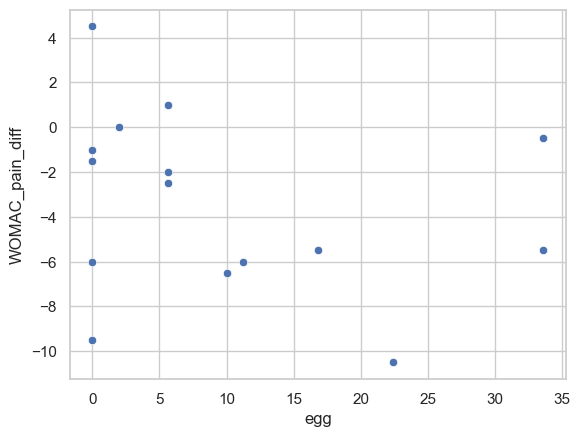

In [22]:
## egg_d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Limivivens_partial_WOMAC_pain_diff_YMX.pdf
df_plot = pd.concat([df_diet,df_X,df_Y],axis=1)
x = 'egg'
m = 'd__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Limivivens'
y = 'WOMAC_pain_diff'

sns.scatterplot(df_plot, x=x, y=y)
scipy.stats.spearmanr(df_plot[x], df_plot[y], nan_policy='omit')

SignificanceResult(statistic=nan, pvalue=nan)

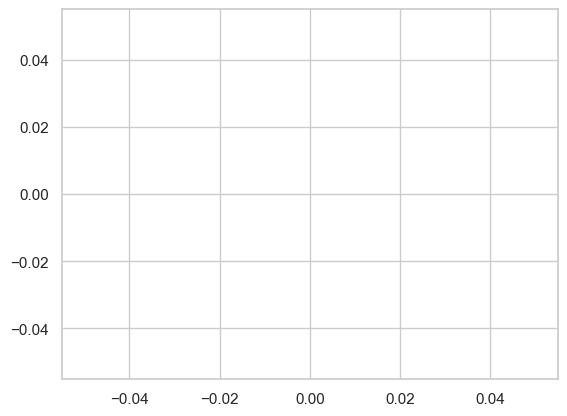

In [23]:
sns.scatterplot(df_plot, x=x, y=m)
scipy.stats.spearmanr(df_plot[x],df_plot[m],nan_policy='omit')

SignificanceResult(statistic=nan, pvalue=nan)

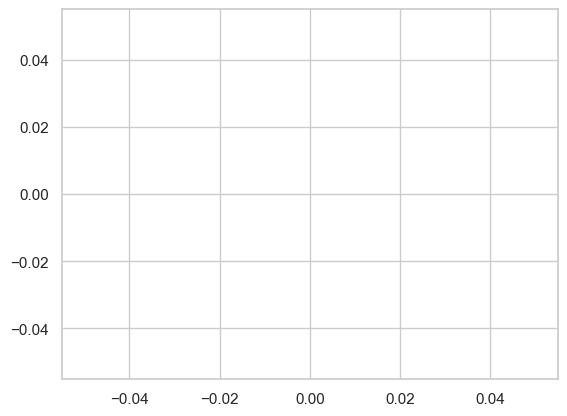

In [24]:
sns.scatterplot(df_plot, x=m, y=y)
scipy.stats.spearmanr(df_plot[m],df_plot[y],nan_policy='omit')

In [25]:
for x in df_diet.columns:
    for y in ['paired_alpha', 'paired_beta']:
        df_merge = pd.concat([df_diet, g_to_dfd['stool_adh'][y]],axis=1)
        ylab = g_to_dfd['stool_adh'][y].columns.values[0]
        r, p = scipy.stats.spearmanr(df_merge[x],df_merge[ylab],nan_policy='omit')
        if p < 0.1:
            print(x,y)
            print(p)
                                     
            plt.figure(figsize=(8,6))
            sns.set_theme(style="whitegrid")        
            sns.scatterplot(data=df_merge,x=x,y=ylab)
            sns.despine()
            plt.tight_layout()
            plt.savefig(path + 'outputs/jobs19/diet_plots/' + x +'_' +ylab + '.pdf')
            plt.close()
g_to_dfd['stool_adh']['paired_alpha'].head()



vegetables paired_beta
0.005573570986881286
PUFA paired_alpha
0.04778181038393539
Nuts paired_alpha
0.0718053516671069
inflammatory_spices paired_beta
0.021128041091560343
sesame_seeds paired_alpha
0.05309411010977


,shannon_entropy_diff
OAD001,0.740699
OAD003,-0.510788
OAD004,0.004809
OAD005,-0.326027
OAD006,-0.239997


number of bootstraps: 100
statistic: total_effect_p
prop under 0.05: 
0.55
mean and std
0.051199999999999996 0.03326499661806687


statistic: direct_effect_p
prop under 0.05: 
0.0
mean and std
0.6058 0.09083149233608354


statistic: indirect_effect_p
prop under 0.05: 
0.05
mean and std
0.10980000000000001 0.04004946940971876


number of bootstraps: 200
statistic: total_effect_p
prop under 0.05: 
0.38
mean and std
0.0524 0.02209615351141461


statistic: direct_effect_p
prop under 0.05: 
0.0
mean and std
0.6138999999999999 0.05740897142433402


statistic: indirect_effect_p
prop under 0.05: 
0.01
mean and std
0.113 0.029410882339705485


number of bootstraps: 1000
statistic: total_effect_p
prop under 0.05: 
0.55
mean and std
0.050300000000000004 0.01037834283496166


statistic: direct_effect_p
prop under 0.05: 
0.0
mean and std
0.6142 0.032411726273063594


statistic: indirect_effect_p
prop under 0.05: 
0.0
mean and std
0.11530000000000001 0.014550257729676132




<Axes: xlabel='indirect_effect_p', ylabel='Density'>

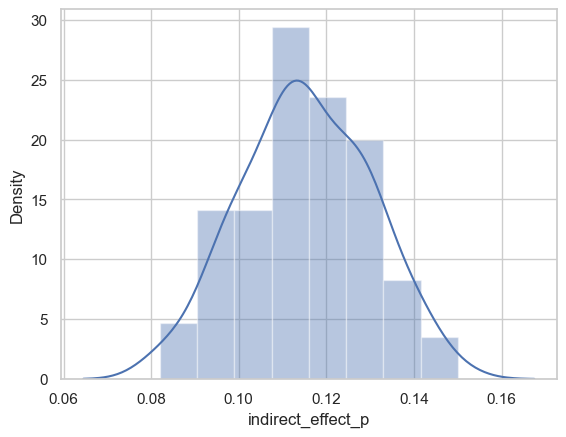

In [26]:
# mediation stability
for p in ['100','200','1000']:
    print('number of bootstraps: ' + p)
    df = pd.read_csv(path + 'outputs/jobs20/df' + p + '.csv')
    for y in ['total_effect_p','direct_effect_p','indirect_effect_p']:
        x = df[y]
        print('statistic: ' + y)
        print('prop under 0.05: ')
        print(len(x[x<0.05])/len(x))
        print('mean and std')
        print(np.mean(x), np.std(x))
        print('\n')
    
sns.distplot(x)

###### Procrustes ######

In [27]:
# Procrustes
import scipy.spatial

str_to_df = {
    'diet': df_diet
}

for g in ['stool', 'saliva']:
    for t in ['Baseline', 'After diet']:
        str_to_df['_'.join([g, t, 'meta'])] = gt_to_meta[g][t]
    for t in['pre', 'post']:
        df = gt_to_otu[g][t]
        df.index = df.index.map(lambda x: x.split('.p')[0].replace('-',''))
        str_to_df['_'.join([g, t, 'taxa'])] = df


def convert_to_pcs(df, npcs):
    pca = PCA(n_components=npcs, whiten=True)
    pca.fit(df.T)
    return pd.DataFrame(pca.components_, 
                        index=['PC%s' % _ for _ in range(npcs)], 
                        columns=df.index).T

#df1 = convert_to_pcs(df1, 10)
#df2 = convert_to_pcs(df2, 10)

# convert to distance matrices
from scipy.spatial.distance import squareform, pdist
from itertools import combinations
from skbio import DistanceMatrix
from skbio.stats.distance import mantel

# get all pairs of dfs
# df_pairs = list(combinations(str_to_df, 2))


# build comparisons list
df_pairs = []
# 'Baseline' 'After diet' # for meta
# 'pre' 'post' # for stool

# stool microbiome nad metabolome at pre and then at post
a = ['stool_pre_taxa', 'stool_Baseline_meta']
b = ['stool_post_taxa', 'stool_After diet_meta']

c = ['saliva_pre_taxa', 'saliva_Baseline_meta']
d = ['saliva_post_taxa', 'saliva_After diet_meta']

# better fit 

# saliva to gut in microbiome at pre and then at post
e = ['saliva_pre_taxa', 'stool_pre_taxa']
f = ['saliva_post_taxa', 'stool_post_taxa']


# repeat for metabolome 
g = ['saliva_Baseline_meta', 'stool_Baseline_meta']
h = ['saliva_After diet_meta', 'stool_After diet_meta']

# worse fit  

df_pairs = [a, b, c, d, e, f, g, h]


for d1, d2 in df_pairs:
    print(d1, d2)
    # retrieve df's 
    df1, df2 = str_to_df[d1], str_to_df[d2]
    
    # convert to distance matrix
    dm1 = pd.DataFrame(squareform(pdist(df1.iloc[:, 1:])), columns=df1.index.unique(), index=df1.index.unique())
    dm2 = pd.DataFrame(squareform(pdist(df2.iloc[:, 1:])), columns=df2.index.unique(), index=df2.index.unique())

    # grab common samples
    shared_idx = list(set(dm1.index).intersection(set(dm2.index)))
    dm1 = dm1.loc[shared_idx,shared_idx]
    dm2 = dm2.loc[shared_idx,shared_idx]

    # compute mantel 
    r, p, n = mantel(x=dm1, y=dm2, method='spearman')
    if p < 0.05:
        print(r,p)

    # compute m2
    df1p, df2p, m2 = scipy.spatial.procrustes(dm1.values,dm2.values)
    print(m2)




stool_pre_taxa stool_Baseline_meta
0.46850198561860124
stool_post_taxa stool_After diet_meta
0.3161328503626619
saliva_pre_taxa saliva_Baseline_meta
0.4658971051150501
saliva_post_taxa saliva_After diet_meta
0.4439332194021862
saliva_pre_taxa stool_pre_taxa
0.6735031124724703
saliva_post_taxa stool_post_taxa
0.42473073458663313
saliva_Baseline_meta stool_Baseline_meta
0.3214470244901641
saliva_After diet_meta stool_After diet_meta
0.3159891086236143


###### PERMANOVA ######

In [77]:
# https://github.com/theJohnnyBrown/permanova/blob/master/permanova.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

# Copyright (C) 2010 - 2012, University of New Orleans
#
# This program is free software; you can redistribute it and/or modify it under
# the terms of the GNU General Public License as published by the Free
# Software Foundation; either version 2 of the License, or (at your option)
# any later version.
#
# Author: Johnny Brown

import numpy as np
import random as r
from itertools import permutations, product, chain

from scipy import stats
#stats.ss chokes on generators. Might be worth fixing that.
stats.ss = lambda l: sum(a*a for a in l)

def above_diagonal(n):
    row = range(n)
    for i in row:
        for j in range(i+1,n):
            yield i,j
    

def permanova_oneway(dm, levels, permutations = 200):
    """ 
    Performs one-way permutational ANOVA on the given distance matrix.

    One-way permanova tests the null hypothesis that distances between levels of
    the variable are not significantly different from distances within levels of
    the variable.

    The test-statistic is a multivariate analogue to Fisher's F-ratio and is 
    calculated directly from any symmetric distance or dissimilarity matrix. 
    P-values are then obtained using permutations.

    In the case of a Euclidean distance matrix calculated from only one 
    variable, the F-value is the same as the traditional parametric univariate 
    F-statistic.

    Parameters
    ----------
    dm : array_like
        The distance matrix of observations x observations. Represents a 
        symmetric n x n matrix with zeros on the diagonal.

    levels : array_like
        An array indicating the levels of the variable at each observation, such
        that levels[i] == levels[j] means that dm[i] and dm[j] are rows 
        corresponding to observations in the same level or treatment.

    permutations : int
        The number of permutations used to compute the p-value. Default is 200.
        If there are less than ``permutations`` unique permutations, then all of 
        them will be used

    Returns
    -------
    F-value : float
        The computed F-value of the test.
    p-value : float
        The associated p-value from the F-distribution, generated by permuting 
        the levels

    Notes
    -----
    It is assumed that all sample groups are the same size, n. 

    For example, if the values in levels are placebo, 5mg, and 10mg, then each 
    value must occur n times in the levels array, and 
    3n == len(levels) == len(dm) == len(dm[i]) (for all 0 <= i < len(dm))
    
    The algorithm is from Anderson[2] 

    References
    ----------
    .. [1] Lowry, Richard.  "Concepts and Applications of Inferential
           Statistics". Chapter 14. http://faculty.vassar.edu/lowry/ch14pt1.html

    .. [2] Anderson, Marti. A new method for non-parametric multivariate analysis 
           of variance. 2001. 
           http://www.entsoc.org/PDF/MUVE/6_NewMethod_MANOVA1_2.pdf
    
    .. [3] Jones, James. Lecture notes for Concepts of Statistics
           http://people.richland.edu/james/lecture/m170/ch13-2wy.html
    """
    bigf = f_oneway(dm,levels)

    above = below = 0
    nf = 0

    #TODO make this pretty with math and functions
    #perms = r.sample(list(perm_unique(levels)),permutations)
    shuffledlevels = list(levels)#copy list so we can shuffle it
    
    for i in range(permutations):
        r.shuffle(shuffledlevels)
        f = f_oneway(dm,shuffledlevels)
        
        if f >= bigf:
            above += 1

        #debug
        ## print shuffledlevels
        ## print f

    p = above/float(permutations)

    return (bigf,p)

#FIXME the right way to reuse code for one-way and n-way is to add an arg f such that
#f(levels[i],levels[j]) returns True iff dm[i][j] should be included in the
#desired sum of squares
def f_oneway(dm,levels):
    bign = len(levels)#number of observations
    dm = np.asarray(dm)#distance matrix
    a = len(set(levels))#number of levels
    n = bign/a#number of observations per level
    
    assert dm.shape == (bign,bign) #check the dist matrix is square and the size
                                   #corresponds to the length of levels

    #total sum of squared distances                                   
    sst = np.sum(stats.ss(r) for r in 
              (s[n+1:] for n,s in enumerate(dm[:-1])) )/float(bign)

    #sum of within-group squares
    #itertools.combinations(range(len(dm)),2)#top half of dm
    ssw = np.sum((dm[i][j]**2 for i,j in  
               product(range(len(dm)),range(1,len(dm)))
               if i<j and levels[i] == levels[j]))/float(n)

    ssa = sst - ssw

    fstat = (ssa/float(a-1))/(ssw/float(bign-a))
    #print (fstat,sst,ssa,ssw,a,bign,n)

    return fstat

def permanova_twoway(dm,levels,permutations=200):
    """Performs one-way permutational ANOVA on the given distance matrix.

    One-way permanova tests the null hypothesis that distances between levels of
    the variable are not significantly different from distances within levels of
    the variable.

    The test-statistic is a multivariate analogue to Fisher's F-ratio and is 
    calculated directly from any symmetric distance or dissimilarity matrix. 
    P-values are then obtained using permutations.

    In the case of a Euclidean distance matrix calculated from only one 
    variable, the F-value is the same as the traditional parametric univariate 
    F-statistic.

    Parameters
    ----------
    dm : array_like
        The distance matrix of observations x observations. Represents a 
        symmetric n x n matrix with zeros on the diagonal.

    levels : array_like
        An array of pairs indicating the levels of the variable at each 
        observation, such that levels[i] == levels[j] means that dm[i] and dm[j] 
        are rows corresponding to observations in the same level or treatment.

    permutations : int
        The number of permutations used to compute the p-value. Default is 200.
        If there are less than ``permutations`` unique permutations, then all of 
        them will be used

    Returns
    -------
    F-values : 3-tuple
        The computed F-values of each test. F-values[0] corresponds to the 
        interaction of the two levels, F-values[1] corresponds to the effect
        of variable a, and F-values[2] corresponds to the effect of variable
        b. 
    p-value : 3-tuple
        The associated p-values from the F-distribution, generated by permuting 
        the levels. The values correspond to (interaction, a, b) as with the 
        F-values.

    Notes
    -----
    All sample groups must be the same size, n. 

    For example, if the variables are drug and dose, with levels 5mg, 10mg, 15mg
    and drug1, drug2, then each combination of drug type and dose level must 
    be of size n, i.e. (5mg, drug1) must occur n times in the levels array and
    6n == len(levels) == len(dm)

    The algorithm is from Anderson[2] 

    References
    ----------
    .. [1] Lowry, Richard.  "Concepts and Applications of Inferential
           Statistics". Chapter 14. http://faculty.vassar.edu/lowry/ch14pt1.html

    .. [2] Anderson, Marti. A new method for non-parametric multivariate analysis 
           of variance. 2001. 
           http://stg-entsoc.bivings.com/PDF/MUVE/6_NewMethod_MANOVA1_2.pdf

    .. [3] Jones, James. Lecture notes for Concepts of Statistics
           http://people.richland.edu/james/lecture/m170/ch13-2wy.html
    """

    bigf_i, bigf_a, bigf_b = f_twoway(dm,levels)

    above_i = above_a = above_b = 0

    #TODO make this pretty with math and functions
    #perms = r.sample(list(perm_unique(levels)),permutations)
    shuffledlevels = list(levels)#copy list so we can shuffle it

    a_levels = list([l[0] for l in levels])
    b_levels = list([l[1] for l in levels])
    
    #permutations
    for i in range(permutations):
        #All these are probably the wrong way to do the permutations. Wrong as in
        #incorrect
        ## r.shuffle(a_levels)
        ## r.shuffle(b_levels)
        ## shuffledlevels = zip(a_levels,b_levels)

        r.shuffle(shuffledlevels)
        
        f_i, f_a, f_b = f_twoway(dm,shuffledlevels)

        if f_i > bigf_i:
            above_i += 1

    for i in range(permutations):
        r.shuffle(a_levels)

        f_i, f_a, f_b = f_twoway(dm,zip(a_levels, [l[1] for l in levels]))

        if f_a > bigf_a:
            above_a += 1

    for i in range(permutations):
        r.shuffle(b_levels)

        f_i, f_a, f_b = f_twoway(dm,zip([l[0] for l in levels], b_levels))
            
        if f_b > bigf_b:
            above_b += 1



    p_i,p_a,p_b = [ above/float(permutations) for above in 
                    [above_i, above_a, above_b]]

    return ((bigf_i, bigf_a, bigf_b), (p_i, p_a, p_b))

    
    
def f_twoway(dm, levels):
    
    bign = len(levels)#number of observations
    dm = np.asarray(dm)#distance matrix
    l = len(set(levels))#number of levels
    a = len(set([l[0] for l in levels]))#number of a-levels
    b = len(set([l[1] for l in levels]))#number of b-levels
    n = bign/float(a*b)#number of observations per level

    #sum of all distances
    ## sst = np.sum(stats.ss(r) for r in 
    ##         (s[n+1:] for n,s in enumerate(dm[:-1])) )/float(bign)
    sst = stats.ss(chain(*(r[i+1:] for i,r in enumerate(dm))))/float(bign)

    #same level of both a and b (error, within-group)
    ssr = select_ss(dm, levels, lambda a,b: a==b)/float(n)

    #same level of a
    sswa = select_ss(dm, levels, lambda a,b: a[0] == b[0])/float(b*n)

    #same level of b
    sswb = select_ss(dm, levels, lambda a,b: a[1] == b[1])/float(a*n)

    
    ssa = sst - sswa#effect of a
    ssb = sst - sswb#effect of b
    ssab = sst - ssa - ssb - ssr #interaction sum-of-squares

    #these should each be separate functions?
    f_interaction = (ssab/float((a-1)*(b-1)))/(ssr/float(bign - a*b))
    f_a = (ssa/float((a-1)))/(ssr/float(bign - a*b))
    f_b = (ssb/float((b-1)))/(ssr/float(bign - a*b))

    return (f_interaction,f_a,f_b)

def select_ss(dm, levels,  included):
    
    bign = len(dm)

    distances = (dm[i][j] for i,j in above_diagonal(bign) 
                           if included(levels[i], levels[j]))

    return stats.ss(distances)

In [78]:
# PERMANOVA
df_dx = df_map.drop_duplicates(subset='HostSubjectId')
df_dx = df_dx.set_index('HostSubjectId')
df_dx.index = df_dx.index.map(lambda x: x.replace('-',''))

# construct dict of data
str_to_df = {
    'diet': df_diet
}

for g in ['stool', 'saliva']:
    for t in ['Baseline', 'After diet']:
        str_to_df['_'.join([g, t, 'meta'])] = gt_to_meta[g][t]

# this is testing resp vs non resp at pre and post time points only, NOT the paired change in beta post-pre 
for label in str_to_df:
    print(label)
    df = str_to_df[label]

    # get merged df and drop na
    df_merge = pd.concat([df, df_dx], axis=1)
    df_merge = df_merge.dropna()
    
    # construct distance matrix from df
    df_data = df.loc[df_merge.index,:]
    dx = df_dx.loc[df_merge.index,:]['WOMAC_P_Response']
    dm = pd.DataFrame(squareform(pdist(df_data.iloc[:, 1:])), columns=df_data.index.unique(), index=df_data.index.unique())

    # takes in distance matrix
    print(permanova_oneway(dm, levels=[1 if x == 'No response' else 0 for x in dx]))

dm.head()

diet
(2.1883126287024086, 0.045)
stool_Baseline_meta
(0.7309599705911948, 0.595)
stool_After diet_meta
(1.0518890722123193, 0.32)
saliva_Baseline_meta
(0.9239761536787098, 0.455)
saliva_After diet_meta
(0.08004394231598018, 0.71)


,VAOAD008,VAOAD011,VAOAD001,OAD004,VAOAD004,OAD001,VAOAD012,OAD006,OAD003,OAD007,OAD012,OAD017,OAD009
VAOAD008,0.000000,7.141737,5.291336,7.374733,3.469745,7.804589,5.751012,5.031966,5.131356,6.885489,6.147435,5.693628,5.464290
VAOAD011,7.141737,0.000000,7.766258,6.376212,8.409915,6.783297,6.827353,5.531482,5.249290,7.679534,8.122889,7.303300,6.146555
VAOAD001,5.291336,7.766258,0.000000,7.348406,5.754649,6.805472,6.221437,5.005707,6.221551,7.627605,4.483618,7.241581,5.189725
OAD004,7.374733,6.376212,7.348406,0.000000,8.787354,3.799295,7.329036,6.306350,6.303166,6.501106,6.413057,6.192060,6.309455
VAOAD004,3.469745,8.409915,5.754649,8.787354,0.000000,8.780640,6.150334,6.608156,6.724492,8.345605,6.708331,7.895603,6.857276


In [30]:
# PERMANOVA OTU
# this is testing resp vs non resp at pre and post time points only, NOT the paired change in beta post-pre 
# PERMANOVA
df_dx = df_map.drop_duplicates(subset='HostSubjectId')
df_dx = df_dx.set_index('HostSubjectId')
df_dx.index = df_dx.index.map(lambda x: x.replace('-',''))

for g in ['stool', 'saliva']:
    df_raw = pd.read_csv(path + 'outputs/Qiime2_' + g + '_adh/core_metrics_results/distance-matrix.tsv', 
                 sep='\t', index_col=0)
    
    for t in ['pre', 'post']:
        # find overlapping samples
        keep = df_dx.dropna().index.values        
        df = df_raw[df_raw.index.str.contains(t)] # df[df.index.str.contains('b')]
        df = df.T
        df = df[df.index.str.contains(t)].T

        # fix strings 
        df.index= df.index.map(lambda x: x.split('.p')[0].replace('-',''))
        df.columns = df.columns.map(lambda x: x.split('.p')[0].replace('-',''))

        # filter indices
        df = df[df.index.isin(keep)] # df[df.index.str.contains('b')]
        df = df.T
        df = df[df.index.isin(keep)].T

        # create dx label
        dx = df_dx.loc[df.index.values,'WOMAC_P_Response']
    
        # takes in distance matrix
        print(permanova_oneway(df, levels=[1 if x == 'No response' else 0 for x in dx]))

df.head()

(0.9741152243294435, 0.37)
(0.6185035360941357, 0.58)
(0.5578591148147687, 0.925)
(0.2900106360994007, 0.755)


,OAD001,OAD003,OAD004,OAD006,OAD007,OAD009,OAD012,OAD017,VAOAD001,VAOAD004,VAOAD011,VAOAD012
OAD001,0.0000,0.7184,0.7239,0.6918,0.8683,0.5698,0.6491,0.6825,0.6369,0.6928,0.5745,0.7305
OAD003,0.7184,0.0000,0.5050,0.5277,0.8907,0.7190,0.5730,0.5424,0.5941,0.7134,0.6239,0.7060
OAD004,0.7239,0.5050,0.0000,0.6775,0.8434,0.6633,0.6060,0.6984,0.6539,0.6216,0.7704,0.5873
OAD006,0.6918,0.5277,0.6775,0.0000,0.9315,0.6965,0.5613,0.4569,0.5652,0.7106,0.5498,0.7555
OAD007,0.8683,0.8907,0.8434,0.9315,0.0000,0.8197,0.8312,0.9177,0.8834,0.8518,0.9342,0.8320


In [31]:
# PCA diet
from sklearn.decomposition import PCA

df = str_to_df['diet']

# get merged df and drop na
df_merge = pd.concat([df, df_dx], axis=1)
df_merge = df_merge.dropna()

# construct distance matrix from df
df_data = df.loc[df_merge.index,:]
dx = df_dx.loc[df_merge.index,:]['WOMAC_P_Response']
dm = pd.DataFrame(squareform(pdist(df_data.iloc[:, 1:])), columns=df_data.index.unique(), index=df_data.index.unique())

# takes in distance matrix
print(permanova_oneway(dm, levels=[1 if x == 'No response' else 0 for x in dx]))

npcs = 3
pca = PCA(n_components=3, whiten=True)
pca.fit(df_data.T)
# Reformat and view results
loadings = pd.DataFrame(pca.components_,
                        index=['PC%s' % _ for _ in range(npcs)], 
                        columns=df_data.index).T

df_merge = pd.concat([df_dx, df_data, loadings], axis=1)
plt.title('Diet_PCA')
sns.scatterplot(data=df_merge, x='PC1', y='PC2', hue='WOMAC_P_Response')
sns.despine()
plt.savefig(path + 'outputs/jobs06/PCA_diet_Response.pdf')
plt.close() 

(2.1883126287024086, 0.095)


###### Scratch ######

In [32]:
# Scratch

In [33]:
gt_to_otu['stool']['pre']

,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Phocaeicola_A_858004,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Agathobacter_164117,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides_H,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;g__Paramuribaculum,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Oscillospirales;f__Ruminococcaceae;g__Gemmiger_A_73129,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;g__Acetatifactor,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes_A_871400,...,d__Bacteria;p__Firmicutes_A;__;__;__;__,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Micrococcaceae;g__Nesterenkonia,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Lactobacillales;__;__,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Peptostreptococcales;f__Anaerovoracaceae;g__S5-A14a,d__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Clostridiales;f__Clostridiaceae_222000;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Azospirillales_507929;f__Azospirillaceae_507917;g__Azospirillum,d__Bacteria;p__Firmicutes_D;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;__,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Sphingomonadales;f__Sphingomonadaceae;g__Sphingomonas_L_486704,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Muribaculaceae;__,d__Bacteria;p__Actinobacteriota;__;__;__;__
index,,,,,,,,,,,,,,,,,,,,,
OAD001,0.022576,0.007098,0.005128,0.000000,0.292202,0.001994,0.013555,0.000000,0.000783,0.026849,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
OAD003,0.181156,0.067844,0.150895,0.063229,0.051360,0.055600,0.012363,0.051513,0.006045,0.025918,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
OAD004,0.170334,0.135468,0.000000,0.002088,0.173617,0.000143,0.000000,0.003649,0.008765,0.054802,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
OAD005,0.040108,0.139385,0.000000,0.018806,0.155290,0.037507,0.024457,0.066852,0.008969,0.018328,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
OAD006,0.037219,0.167448,0.000000,0.007940,0.019591,0.000000,0.011006,0.001275,0.012769,0.162962,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
OAD007,0.125157,0.264931,0.000511,0.028658,0.173716,0.000000,0.009503,0.053225,0.015490,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
OAD008,0.159498,0.023745,0.330812,0.018649,0.046382,0.000000,0.019323,0.073876,0.000469,0.004811,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
OAD009,0.000452,0.159093,0.000126,0.000000,0.181472,0.000000,0.059154,0.004245,0.029098,0.000235,...,0.0,0.000054,0.000000,0.0,0.000000,0.0,0.0,0.000036,0.000000,0.000000
OAD012,0.265874,0.046968,0.000000,0.000000,0.340663,0.039309,0.021248,0.000000,0.009413,0.020631,...,0.0,0.000000,0.000074,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000


In [34]:
# correlations of taxa of interest with metabolites
gtr_to_otucorr = {}
for g in ['saliva','stool']:
    print(g)
    gtr_to_otucorr[g] = {}
    for time in ['diff','all']:
        print(time)
        gtr_to_otucorr[g][time] = {}
        # grab otu table of differences or of all samples
        df_otu = gt_to_otu[g][time]
        for comp in ['horizontal', 'vertical']:
            if comp == 'vertical':
                gr_to_sigotu = to_sigotu[comp]
                rvs = ['pre', 'post']
            elif comp == 'horizontal':
                gr_to_sigotu = to_sigotu[comp]
                rvs = ['Response', 'No response']
            for rv in rvs: # ['pre', 'post']: # Response No response
                print(rv)
                sigcorr = []
                # grab taxa of interest
                taxa_int = gr_to_sigotu[g][rv]
    
                # merge otu table with metabolites            
                df_merge = pd.concat([df_otu.loc[:,taxa_int], gt_to_meta[g][time]], axis=1)
                meta = gt_to_meta[g][time].columns
                
                # look at taxa int and correlate with metabolites
                # df_merge 
                for t in taxa_int:
                    for m in meta:
                        df_sub = df_merge.loc[:,[t,m]]
                        df = type_to_df_map[g].copy()
                        if time is 'all':
                            df = df.set_index('Together')
                            if g == 'stool':
                                df.index = df.index.map(lambda x: x.split('.guma')[0])
                        elif time is 'diff':
                            df = df[df['Timepoint'] == 'pre']
                        df_sub = pd.concat([df_sub, df['WOMAC_P_Response']],axis=1)
                        df_sub = df_sub.dropna(subset=[t,m])
                        r, p = scipy.stats.spearmanr(df_sub[t].values, df_sub[m].values)
                        if p < 0.05:
                            sigcorr.append([t,m])
                            sns.scatterplot(data=df_sub, x=t, y=m, hue='WOMAC_P_Response')
                            sns.despine()
                        
                            plt.tight_layout()
                            plt.savefig(path + 'outputs/' + g_to_job[g + '_adh'] + '/corr_taxa_' + comp + '_' + time + '_' + t.split(';g__')[-1] + '_' + m.replace('/','fslash') + '.pdf')
                            plt.close()   
                gtr_to_otucorr[g][time][rv] = sigcorr
                print(len(sigcorr))
           


saliva
diff


NameError: name 'to_sigotu' is not defined

In [ ]:
# correlations of pathways of interest with metabolites
gtr_to_pathcorr = {}
for g in ['saliva','stool']:
    print(g)
    gtr_to_pathcorr[g] = {}
    for time in ['diff','all']:
        print(time)
        gtr_to_pathcorr[g][time] = {}
        # grab otu table of differences or of all samples
        df_path = gt_to_path[g][time]
        for comp in ['horizontal', 'vertical']:
            if comp == 'vertical':
                gr_to_sigpath = to_sigpath[comp]
                rvs = ['pre', 'post']
            elif comp == 'horizontal':
                gr_to_sigpath = to_sigpath[comp]
                rvs = ['Response', 'No response']
            for rv in rvs: # ['pre', 'post']: # Response No response
                print(rv)
                sigcorr = []
                # grab taxa of interest
                taxa_int = gr_to_sigpath[g][rv]
    
                # merge otu table with metabolites            
                df_merge = pd.concat([df_path.loc[:,taxa_int], gt_to_meta[g][time]], axis=1)
                meta = gt_to_meta[g][time].columns
                
                # look at taxa int and correlate with metabolites
                # df_merge 
                for t in taxa_int:
                    for m in meta:
                        df_sub = df_merge.loc[:,[t,m]]
                        df = type_to_df_map[g].copy()
                        if time is 'all':
                            df = df.set_index('Together')
                            if g == 'stool':
                                df.index = df.index.map(lambda x: x.split('.guma')[0])
                        elif time is 'diff':
                            df = df[df['Timepoint'] == 'pre']
                        df_sub = pd.concat([df_sub, df['WOMAC_P_Response']],axis=1)
                        df_sub = df_sub.dropna(subset=[t,m])
                        r, p = scipy.stats.spearmanr(df_sub[t].values, df_sub[m].values)
                        if p < 0.05:
                            sigcorr.append([t,m])
                            sns.scatterplot(data=df_sub, x=t, y=m, hue='WOMAC_P_Response')
                            sns.despine()
                        
                            plt.tight_layout()
                            plt.savefig(path + 'outputs/' + g_to_job[g + '_adh'] + '/corr_path_' + comp + '_' + time + '_' + t.split(';g__')[-1] + '_' + m.replace('/','fslash') + '.pdf')
                            plt.close()   
                gtr_to_pathcorr[g][time][rv] = sigcorr
                print(len(sigcorr))



In [ ]:
# L Methionine
# Kaempferol
# Tryptophan
# Tyrosine Stool
# Usnic acid
# Xanthurenic acid
# Tryhydroxycholestenoic acid Stool
# Isofraxadine
int = ['Isofrax', 'Xanth', 'ydroxychol', 'Usnic', 'Tyrosine', 'Tryptophan', 'Kaempferol', 'Methion']

for g in ['stool','saliva']:
    for time in ['diff','all']:
        for r in ['Response', 'No response']:
            test = gtr_to_pathcorr[g][time][r]
            for t in test:
                p, m = t # unpack pathway, metabolite, from tuple representing sig corr
                for i in int:
                    if i in m:
                        print(t)
    

In [ ]:
int = ['Isofrax', 'Xanth', 'ydroxychol', 'Usnic', 'Tyrosine', 'Tryptophan', 'Kaempferol', 'Methion']

for g in ['stool','saliva']:
    for time in ['diff','all']:
        for r in ['Response', 'No response']:
            test = gtr_to_otucorr[g][time][r]
            for t in test:
                p, m = t # unpack pathway, metabolite, from tuple representing sig corr
                for i in int:
                    if i in m:
                        print(t)
    

In [ ]:
# CUTIE
# In POST samples only
# Color by Resp and Nonresp

for g in ['saliva', 'stool']:

    df_taxa = gt_to_otu[g]['post']
    df_taxa.to_csv(path + 'inputs/cutie_df_taxa_' + g + '.tsv', sep='\t', index_label='SampleID')
    
    df_abun = pd.concat([gt_to_otu[g]['post'], gt_to_path[g]['post']],axis=1)
    df_abun.index = df_abun.index.map(lambda x: x.split('.post')[0].replace('-',''))
    
    df_map = type_to_df_map[g].set_index('Together')
    df_map = df_map[df_map['Timepoint'] == 'post']['WOMAC_P_Response']
    df_map.index = df_map.index.map(lambda x: x.split('.post')[0].replace('-',''))
    
    df_meta = pd.concat([gt_to_meta[g]['After diet'],df_map], axis=1)

    df_abun.to_csv(path + 'inputs/cutie_df_abun_' + g + '.tsv', sep='\t', index_label='SampleID')
    df_meta.to_csv(path + 'inputs/cutie_df_meta_' + g + '.tsv', sep='\t', index_label='SampleID')

df_meta.head()

In [ ]:
# anaerobic vs aerobic in response
# bile acids -> list? saliva and stool of interest 
#
# Bile acids found in Stool: 
int_ba = {'stool': ['L_methionine', 'Pentahydroxylated_bile_acid', 'Dihydroxylated_bile_acid',
                    'Trihydroxylated_bile_acid', 'Glycocholic_acid', 'Glycocholate',
                    'Glycocholic_acid', 'Tetrahydroxylated_bile_acid', 'Glycochenodeoxycholate',
                    'Deoxycholate', 'Hydroxyhexadecanoyl_lysine', 'Deoxycholic_acid'
                    'Trihydroxycholestanoic_acid', 'Phenylalanine_conjugated_chenodeoxycholic_acid', 'Nonhydroxylated_bile_acid',
                    'Monohydroxylated_bile_acid'],
          'saliva': ['Trihydroxylated_bile_acid', 'Palmitoylcarnitine', 'Palmitoyl_ethanolamide']
         }

mod_ba = {
    'stool': [],
    'saliva': []
}
full = list(gt_to_meta[g]['After diet'].columns.values)
for g in ['stool','saliva']:
    ba = int_ba[g]
    for b in ba:
        for f in full:
            if b in f:
                mod_ba[g].append(f)

g_to_cutiejob = {
    'saliva': 'jobs15',
    'stool': 'jobs16'
}


# from difflib import SequenceMatcher

for g in ['stool','saliva']:
    print(g)
    n_corr = 0
    # import CUITIE results
    df_qt = pd.read_csv(path + 'outputs/' + g_to_cutiejob[g] + '/data_processing/summary_df_resample_1.txt', sep='\t')
    df_qt = df_qt[df_qt['class'] == 'TP']
    # iterate through rows
    for r in range(len(df_qt)):
        meta = df_qt.iloc[r,0]
        abun = df_qt.iloc[r,1]
        
        #for i in int_ba:
        #    s = SequenceMatcher(None, meta, i)
        #    if s.ratio() > 0.9:
        #        print(i)
        
        #if 'bile' in meta:
        #    print(meta)
        output = [r]
        
        for i in int_ba[g]:
            if i in meta:
                output.append(meta)

        for c in ['horizontal','vertical']:
            if c == 'vertical':
                queries = ['pre', 'post']
            if c == 'horizontal':
                queries = ['Response','No response']
            output.append(c)
            for r in queries:
                int_taxa = to_sigotu[c][g][r]
                for i in int_taxa:
                    if i in abun:
                        output.append('taxa')
                        output.append(i)
                int_path = to_sigpath[c][g][r]
                for i in int_path:
                    if i in abun:
                        output.append('path')
                        output.append(i)
        #output.append()
        #output.append()
        if len(output) > 5:
            # print(output)
            n_corr += 1

    print(n_corr)

# pathway prediction of response vs non response @ baseline
# specific taxa at baseline


# pathways of interest
# ex inflammation in non responders
# heatmap of differential pathways in responders/nonresponders 
# and correlation of those pathways with bacteria
# send list of upregulated pathways 

int_taxa

In [ ]:
# annotations for pathways
int_ba = {'stool': ['L_methionine', 'Pentahydroxylated_bile_acid', 'Dihydroxylated_bile_acid',
                    'Trihydroxylated_bile_acid', 'Glycocholic_acid', 'Glycocholate',
                    'Glycocholic_acid', 'Tetrahydroxylated_bile_acid', 'Glycochenodeoxycholate',
                    'Deoxycholate', 'Hydroxyhexadecanoyl_lysine', 'Deoxycholic_acid'
                    'Trihydroxycholestanoic_acid', 'Phenylalanine_conjugated_chenodeoxycholic_acid', 'Nonhydroxylated_bile_acid',
                    'Monohydroxylated_bile_acid'],
          'saliva': ['Trihydroxylated_bile_acid', 'Palmitoylcarnitine', 'Palmitoyl_ethanolamide']
         }

for g in ['saliva','stool']:
    # int_ba[g] for metabolite (row) annotations
    #df_map = type_to_df_map[g].set_index('Together')
    #df_map = df_map[df_map['Timepoint'] == 'post']['WOMAC_P_Response']
    #df_map.index = df_map.index.map(lambda x: x.split('.post')[0].replace('-',''))
    
    #df_meta = pd.concat([gt_to_meta[g]['After diet'],df_map], axis=1)
    df_meta = gt_to_meta[g]['After diet']
    df_meta_R = df_meta.T
    df_meta_R['var_type'] = df_meta_R.index.map(lambda x: 'BA' if x in mod_ba[g] else 'NonBA')
    df_meta_R = df_meta_R['var_type'].reset_index()
    # df_meta_R['index'] = df_meta_R['index'].str.lower()
    df_meta_R = df_meta_R.sort_values(by='index',ascending=True)
    df_meta_R.to_csv(path + 'inputs/row_' + g + '.tsv', sep='\t')
    
    # dcgr_to_sig for column (taxa) annotations
    df_abun = gt_to_otu[g]['post']
    df_abun.index = df_abun.index.map(lambda x: x.split('.post')[0].replace('-',''))
    
    df_abun_R = df_abun.T
    df_abun_R['var_type'] = df_abun_R.index.map(lambda x: 'Sig' if x in dcgr_to_sig['taxa']['rvnr'][g]['Response'] else 'Nonsig')
    df_abun_R = df_abun_R['var_type'].reset_index()
    #df_abun_R['index'] = df_abun_R['index'].str.lower()
    df_abun_R = df_abun_R.sort_values(by='index',ascending=True)
    df_abun_R.to_csv(path + 'inputs/col_' + g + '.tsv', sep='\t')

df_abun_R.head()

In [ ]:
# play testing mediation
g = 'stool'
df_M = pd.read_csv(path + 'inputs/cutie_df_meta_stool.tsv', sep='\t', index_col=0)
df_M.iloc[:,:-1].to_csv(path + 'inputs/mediation_meta_stool_post_test.txt', sep='\t')

df_Y = df_meta_paired[['VAS_Pt_diff', 'WOMAC_pain_diff']]
df_Y.to_csv(path + 'inputs/mediation_WMdiff_test.txt', sep='\t')

df_X = pd.read_csv(path + 'inputs/cutie_df_taxa_stool.tsv', sep='\t', index_col=0)
df_X.index = df_X.index.map(lambda x: x.split('.post')[0].replace('-',''))
df_X.to_csv(path + 'inputs/mediation_taxa_stool_post_test.txt', sep='\t')
df_X.head()


In [ ]:
# for corr heatmaps 
for g in ['saliva','stool']:
    df_abun = pd.concat([gt_to_otu[g]['post'], gt_to_path[g]['post']],axis=1)
    df_abun.index = df_abun.index.map(lambda x: x.split('.post')[0].replace('-',''))
    
    df_map = type_to_df_map[g].set_index('Together')
    df_map = df_map[df_map['Timepoint'] == 'post']['WOMAC_P_Response']
    df_map.index = df_map.index.map(lambda x: x.split('.post')[0].replace('-',''))
    
    df_meta = pd.concat([gt_to_meta[g]['After diet'],df_map], axis=1)

    df_quant_R = df_abun.copy()
    #df_quant_R = pd.concat([df_abun, df_meta],axis=1)# .copy() #([df_quant, df_asv100, df_path_top100], axis=1)
    # df_quant_R = df_quant_R.drop(['WOMAC_P_Response'],axis=1)
    # df_quant_R.to_csv(path + 'inputs/df_quant_' + g + '.tsv', sep='\t')
    df_quant_R = df_quant_R.T
    # this is in the order they were entered i.e. 
    # [df_olink, df_fa, df_acpa_fecal, df_acpa_plasma, df_plasma, df_rbfa, df_mb]
     # ['rbfa']*len(df_rbfa.columns) + \  
    df_quant_R['var_type'] = ['Taxa']*len(gt_to_otu[g]['post'].columns) + \
                             ['Pathways']*len(gt_to_path[g]['post'].columns) # + \
                             # ['Metabolite']*len(gt_to_meta[g]['After diet'].columns)
    # df_quant_R = df_quant_R[~df_quant_R['var_type'].isin(['Metagenomic_ASVs','Metagenomic_Pathways'])]
    df_quant_R = df_quant_R['var_type'].reset_index()
    df_quant_R['index'] = df_quant_R['index'].str.lower()
    df_quant_R = df_quant_R.sort_values(by='index',ascending=True)
    df_quant_R.to_csv(path + 'inputs/df_quant_R_corr_labels_' + g + '.tsv', sep='\t')
    print(len(df_quant_R))
df_quant_R.head()

In [ ]:
# 4 way paired boxplot trial
g = 'saliva'
df_alpha = g_to_dfd[g + '_adh']['alpha']

df_map = type_to_df_map[g].copy()
df_map = df_map.set_index('Together')
df_map = df_map[['Timepoint','WOMAC_P_Response']]

df_merge = pd.concat([df_alpha, df_map], axis=1)
df_merge = df_merge.dropna()

sns.boxplot(x='Timepoint', y='shannon_entropy',
            hue='WOMAC_P_Response', palette=["r", "g"],
            data=df_merge)
sns.despine()

In [ ]:
# test if each sub correlation is sig
m = 'H_Nonhydroxylated_bile_acid'
y = 'WOMAC_pain_diff'
y = 'VAS_Pt_diff'
x = 'd__Bacteria;p__Firmicutes_A;c__Clostridia_258483;o__Lachnospirales;f__Lachnospiraceae;__'

df = df_plot[[x,y,m]]

df_corr = df.dropna()
print('Y on X')
print(scipy.stats.pearsonr(df_corr[y].values, df_corr[x].values))
print('M on X')
print(scipy.stats.pearsonr(df_corr[m].values, df_corr[x].values))

df['meta'] = df[m].apply(lambda x: 'high' if -1.25 <= x <= 0.25 else 'low')

# do each linear model separately
df_corr = df[df['meta'] == 'low']
df_corr = df_corr.dropna()
print(scipy.stats.pearsonr(df_corr[y].values, df_corr[x].values))

df_corr = df[df['meta'] == 'high']
df_corr = df_corr.dropna()
print(scipy.stats.pearsonr(df_corr[y].values, df_corr[x].values))
# df_corr
df.columns = ['Lachno','Pain','H_Nonhydroxylated_BA', 'meta']
df.to_csv(path + 'inputs/df_med_R.tsv', sep='\t')
df

In [ ]:

# df

In [ ]:
uniq_to_taxa['OAD005']

In [ ]:
df = pd.read_csv(path + 'outputs/Qiime2_saliva_adh_withOAD007/level-6.csv', index_col=0)
# df = pd.read_csv(path + 'outputs/Qiime2_stool_adh/level-6.csv', index_col=0)
df = pd.read_csv(path + 'outputs/Qiime2_saliva_adh/level-6.csv', index_col=0)
keep = []
for x in df.columns:
    if 'd__' in x:
        keep.append(x)
df = df[keep]


# df = gt_to_otu['saliva']['post']

uniques = []
from collections import defaultdict
uniq_to_taxa = defaultdict(list)
for t in df.columns:
    if df[t].nunique() == 2:
        x = df[t]
        x = x[x != 0]
        uniques.append(x.index[0])
        uniq_to_taxa[x.index[0]].append(t)
pd.Series(uniques).value_counts()
# df = df.astype(bool).sum(axis=1)

#df = df.loc['OAD-007.post.saliva',:]
#df = df[df > 0]

#len(df)

In [ ]:
df